In [17]:
import torch
import torch.nn.functional as F

In [18]:
scores = torch.rand(10)
tk = scores.topk(5).indices

In [19]:
w = torch.tensor([1/(k+1) for k in range(5)], dtype=torch.float32, requires_grad=True)

s = F.softmax(w, dim=0)
ls = F.log_softmax(w, dim=0)
w,s,ls

(tensor([1.0000, 0.5000, 0.3333, 0.2500, 0.2000], requires_grad=True),
 tensor([0.3288, 0.1994, 0.1688, 0.1553, 0.1477], grad_fn=<SoftmaxBackward0>),
 tensor([-1.1124, -1.6124, -1.7791, -1.8624, -1.9124],
        grad_fn=<LogSoftmaxBackward0>))

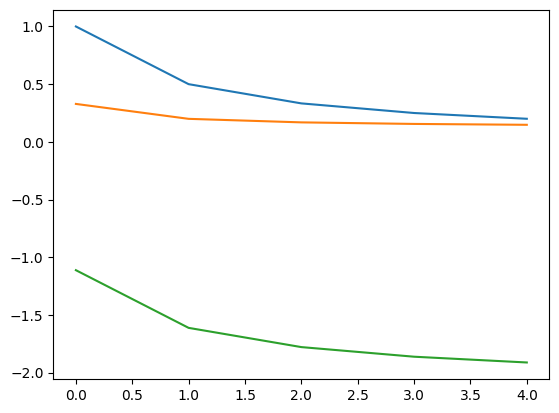

In [20]:
import matplotlib.pyplot as plt

plt.plot(w.detach().numpy(), label='w')
plt.plot(s.detach().numpy(), label='s')
plt.plot(ls.detach().numpy(), label='ls')

In [23]:
w, scores, scores[tk], scores[tk] * w, scores[tk] * s, scores[tk] * ls

(tensor([1.0000, 0.5000, 0.3333, 0.2500, 0.2000], requires_grad=True),
 tensor([0.9205, 0.1195, 0.4207, 0.6318, 0.1963, 0.6741, 0.1797, 0.6193, 0.7459,
         0.0239]),
 tensor([0.9205, 0.7459, 0.6741, 0.6318, 0.6193]),
 tensor([0.9205, 0.3729, 0.2247, 0.1580, 0.1239], grad_fn=<MulBackward0>),
 tensor([0.3026, 0.1487, 0.1138, 0.0981, 0.0915], grad_fn=<MulBackward0>),
 tensor([-1.0239, -1.2026, -1.1992, -1.1767, -1.1844], grad_fn=<MulBackward0>))

In [25]:
lscores = torch.zeros_like(scores)
lscores[tk] = scores[tk] * ls

In [26]:
lscores

tensor([-1.0239,  0.0000,  0.0000, -1.1767,  0.0000, -1.1992,  0.0000, -1.1844,
        -1.2026,  0.0000], grad_fn=<IndexPutBackward0>)

In [ ]:
scores[tk] = scores[tk] * w

In [28]:
scores = torch.rand(10)
tk = scores.topk(5).indices

w = torch.tensor([1/(k+1) for k in range(5)], dtype=torch.float32, requires_grad=True)
ls = F.log_softmax(w, dim=0)

lscores = torch.zeros_like(scores)
lscores[tk] = scores[tk] * ls
scores, lscores

(tensor([0.2354, 0.6039, 0.3375, 0.7665, 0.7575, 0.3047, 0.1899, 0.9926, 0.5916,
         0.6377]),
 tensor([ 0.0000, -1.1550,  0.0000, -1.2360, -1.3476,  0.0000,  0.0000, -1.1042,
          0.0000, -1.1876], grad_fn=<IndexPutBackward0>))

In [30]:
label = torch.tensor([3])
criterion = torch.nn.NLLLoss()

loss = criterion(lscores.unsqueeze(0), label)
loss

tensor(1.2360, grad_fn=<NllLossBackward0>)

In [31]:
torch.nn.CrossEntropyLoss()(scores.unsqueeze(0), label)

tensor(2.1095)

In [9]:
with open("out/official/20241230_225438/predictions.csv", "r") as f:
    lines = f.readlines()
    sorted_lines = [lines[0]] + sorted(lines[1:], key=lambda x: x.split(",")[0])
    out = open("out/official/20241230_225438/predictions_sorted.csv", "w")
    out.writelines(sorted_lines)
    out.close()
    

In [9]:
lines = string.split("\n")[2:]
ids = [line.split(",")[0] for line in lines if line]
set(ids)

{'015feb78.jpg',
 '1b1cb42a.jpg',
 '1bb5fbe9.jpg',
 '2087ab41.jpg',
 '24f6dcbc.jpg',
 '305d1b35.jpg',
 '3a88e5ef.jpg',
 '3f4e9298.jpg',
 '5a4adfa7.jpg',
 '6d071aa8.jpg',
 '781377a0.jpg',
 '8061d124.jpg',
 'bb4a8f50.jpg',
 'bc18ebce.jpg',
 'd23113d9.jpg',
 'ec4866fa.jpg'}

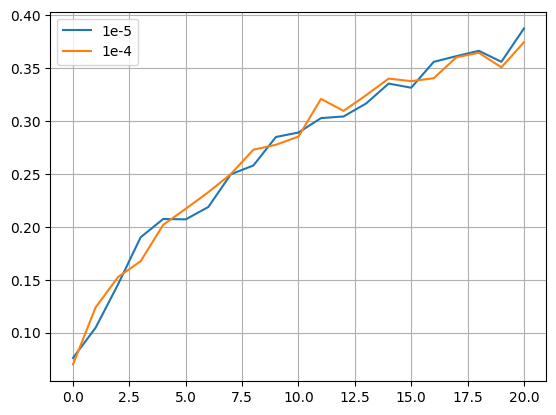

In [2]:
v1 = [
        0.07604498416185379,
        0.10456261783838272,
        0.14569273591041565,
        0.19009898602962494,
        0.20735259354114532,
        0.2070314735174179,
        0.218670055270195,
        0.24960772693157196,
        0.2579210698604584,
        0.2848547399044037,
        0.2890629172325134,
        0.3027104437351227,
        0.3042353689670563,
        0.3165213465690613,
        0.33531108498573303,
        0.3314245045185089,
        0.3558604121208191,
        0.3612196147441864,
        0.3662866950035095,
        0.3559005856513977,
        0.38739240169525146
    ]

v2 = [
        0.06988752633333206,
        0.1237620860338211,
        0.15255458652973175,
        0.1674702763557434,
        0.20187221467494965,
        0.21703679859638214,
        0.23265865445137024,
        0.24979031085968018,
        0.2728385627269745,
        0.27750009298324585,
        0.285277396440506,
        0.3208503723144531,
        0.30952364206314087,
        0.32433685660362244,
        0.3400312066078186,
        0.3376306891441345,
        0.3404051661491394,
        0.36010029911994934,
        0.36443614959716797,
        0.3506524860858917,
        0.3743954002857208
    ]

import matplotlib.pyplot as plt

plt.plot(v1)
plt.plot(v2)
plt.grid()
plt.legend(["1e-5", "1e-4"])

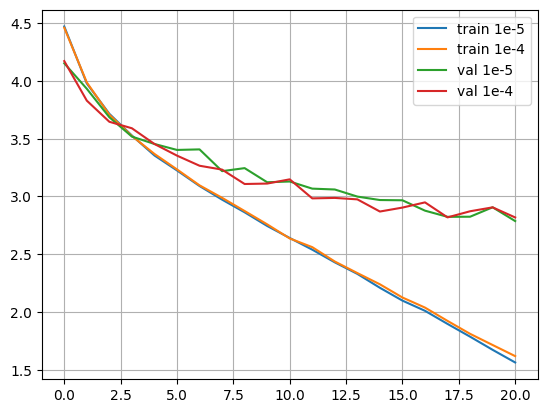

In [5]:
train_losses1 = [
        4.4712112520443705,
        3.978086848102829,
        3.7152278729590122,
        3.5273578383159876,
        3.3547287587855266,
        3.22527598493946,
        3.090318760883898,
        2.972516169776244,
        2.862917459281326,
        2.744655047916345,
        2.6406436428915643,
        2.539496624199509,
        2.42970525407671,
        2.329745886007544,
        2.2095151887432456,
        2.0984824655638534,
        2.0103318829380297,
        1.8967572762924116,
        1.7864145313762598,
        1.672578717058792,
        1.563102173865292
    ]
val_losses1 = [
    4.1526833118352675,
    3.931865364089048,
    3.6855197938761317,
    3.5180778395860717,
    3.454405691390647,
    3.402655868601978,
    3.407393987913777,
    3.219123281034312,
    3.2451847782708647,
    3.1229889572114873,
    3.1293954132194806,
    3.0677109553401634,
    3.0602846127703676,
    2.9989108411889327,
    2.9690726690722586,
    2.9668556227719876,
    2.877109056128595,
    2.823608156433679,
    2.8246182427370456,
    2.9061669595259474,
    2.7869775510372077
]

train_losses2 = [
        4.4599807947048316,
        3.986899143502454,
        3.707446957114962,
        3.523490933987596,
        3.3681379103240197,
        3.2339829581810786,
        3.0962501563113043,
        2.9883406312399607,
        2.873989565846902,
        2.75866896980055,
        2.6366450600419897,
        2.561292794549495,
        2.4368942630681345,
        2.337043546309099,
        2.2397296906118127,
        2.1254013611627767,
        2.038106669406747,
        1.9227761144301754,
        1.8110154131497784,
        1.7143884335717265,
        1.6181304490836501
    ]

val_losses2 = [
        4.171756860905123,
        3.8293172829133226,
        3.64642610227255,
        3.5901844609052613,
        3.454080515338066,
        3.353397944816073,
        3.26593544070882,
        3.232415426942639,
        3.1078176821084846,
        3.1115775699902297,
        3.148191079161221,
        2.983414275305612,
        2.987445383143604,
        2.974838964921191,
        2.869559727217022,
        2.9037389853843174,
        2.9487596839890444,
        2.8188961484378443,
        2.871830513602809,
        2.9057451791333078,
        2.81833116990283
    ]

plt.plot(train_losses1, label="train 1e-5")
plt.plot(train_losses2, label="train 1e-4")
plt.plot(val_losses1, label="val 1e-5")
plt.plot(val_losses2, label="val 1e-4")
plt.legend()
plt.grid()

In [48]:
from sklearn.model_selection import train_test_split

X = list(range(10))
y = list(range(3)) * 3 + [2]
X_train, X_test = train_test_split(
    X, test_size=0.4, random_state=42, shuffle=True, stratify=None
    )

X_train, X_test

([7, 2, 9, 4, 3, 6], [8, 1, 5, 0])

In [54]:
from torchvision.datasets import VisionDataset
from torch.utils.data import Subset
import torch

class MyDataset(VisionDataset):
    def __init__(self, root="", transform=None, target_transform=None):
        super(MyDataset, self).__init__(root, transform=transform, target_transform=target_transform)

        self.x = torch.rand(10)
        self.y = torch.randint(0, 3, (10,))
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)
        
        
mydataset = MyDataset("")

subset = Subset(mydataset, list(range(5)))

isinstance(mydataset, Subset)

False

### Best configuration for random backbone up to now

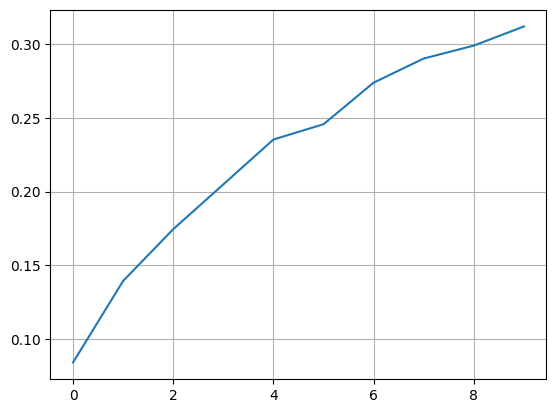

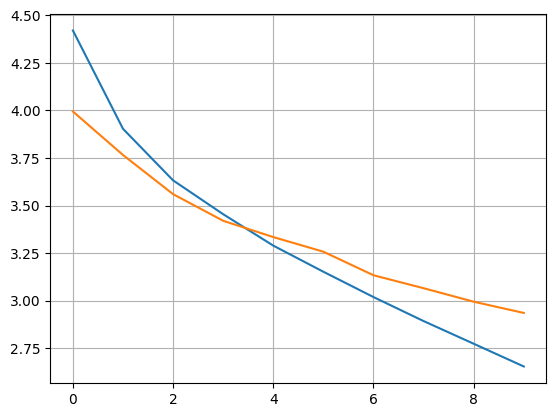

In [4]:
val_accuracies = [
    0.08419206738471985,
    0.1394469290971756,
    0.17452268302440643,
    0.2048742026090622,
    0.23529750108718872,
    0.24567946791648865,
    0.2738375961780548,
    0.2901918590068817,
    0.298961341381073,
    0.31191524863243103
]

train_losses = [
    4.420879250456547,
    3.903659423877453,
    3.632515722821499,
    3.454458996139724,
    3.289269699104901,
    3.151839817392415,
    3.018707375588088,
    2.892420737393971,
    2.773215157204661,
    2.6536322151278626
]

val_losses = [
    3.9949151563644407,
    3.7660061812400816,
    3.560041229724884,
    3.4198405504226685,
    3.334247932434082,
    3.2572472620010378,
    3.1334413290023804,
    3.0652887058258056,
    2.994322199821472,
    2.935179829597473
]

import matplotlib.pyplot as plt

plt.figure()
plt.plot(val_accuracies)
plt.grid()

plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.grid()

### Custom plot for config

In [60]:
import json
PATH= lambda cfg: f"out/official/{cfg}/result.json"
CFG = "20250107_161635"
fin = open(PATH(CFG), mode="r", encoding="utf-8")
result = json.load(fin)

train_losses, val_losses, val_accuracies = map(result.get, ["train_losses", "val_losses", "val_accuracies"])

train_losses, val_losses, val_accuracies

([4.410600761401242,
  3.903098978872957,
  3.6547785704505853,
  3.462937884289643,
  3.3036755785859864,
  3.1603856996215622,
  3.0350392738292955,
  2.911855239292671,
  2.7891539160547585,
  2.6663533402927992,
  2.5435597179778693,
  2.4408044517040253,
  2.341465444400393,
  2.222822291840767],
 [4.081306798458099,
  3.7705239725112913,
  3.5889788365364073,
  3.4426308035850526,
  3.335531704425812,
  3.2492643117904665,
  3.1736767625808717,
  3.0687943387031553,
  3.0263093662261964,
  2.984197404384613,
  2.8761298298835754,
  2.8669380211830138,
  2.8576572835445404,
  2.758475309610367],
 [0.09291042387485504,
  0.12939222157001495,
  0.1748776137828827,
  0.20607900619506836,
  0.22901120781898499,
  0.2530072033405304,
  0.26732879877090454,
  0.2988360524177551,
  0.2945624589920044,
  0.32478854060173035,
  0.33495208621025085,
  0.3402288854122162,
  0.34832873940467834,
  0.36750510334968567])

In [23]:
train_losses = [
    4.426035417564984,
    3.9249098352317153,
    3.6724167383950332,
    3.472135620384381,
    3.3127809136078277,
    3.173696221976445,
    3.0450885198239623,
    2.9120668522242843,
    2.802133045833686,
    2.6796454792392663,
    2.5715141460813324,
    2.457955703139305,
    2.349190111561068,
    2.246277039421016
]
val_losses = [
    4.0576200199127195,
    3.750187599658966,
    3.6170818495750425,
    3.47578813791275,
    3.374278621673584,
    3.320884954929352,
    3.3632968711853026,
    3.1140793657302854,
    2.996187597513199,
    2.9600464129447936,
    2.966615837812424,
    2.911357126235962,
    2.8560305047035217,
    2.7559532725811007
]
val_accuracies = [
    0.08551990985870361,
    0.14993029832839966,
    0.1658024787902832,
    0.1906375139951706,
    0.22807137668132782,
    0.2441190928220749,
    0.248162642121315,
    0.28240033984184265,
    0.30268606543540955,
    0.3153406083583832,
    0.32531553506851196,
    0.3358810842037201,
    0.344297856092453,
    0.36870697140693665
]

In [61]:
trn_losses = train_losses
vld_losses = val_losses
vld_acc = val_accuracies

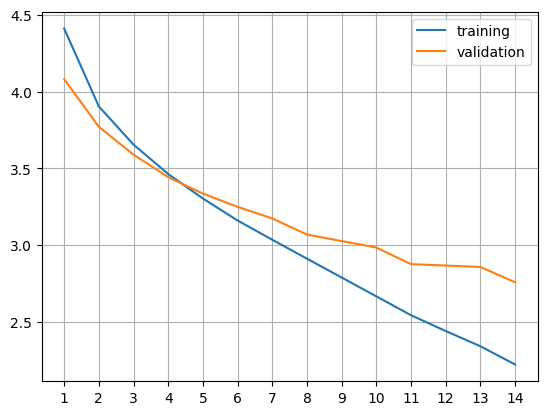

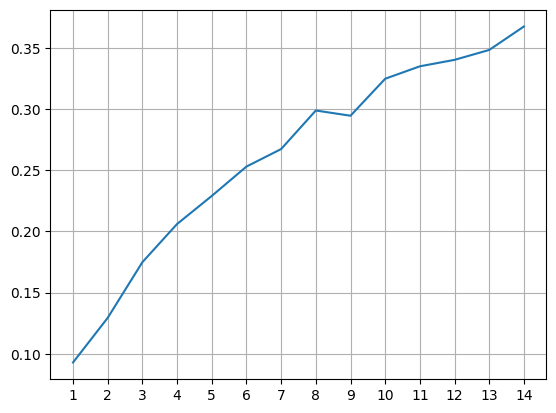

In [62]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(trn_losses, label="training")
plt.plot(vld_losses, label="validation")
plt.xticks(range(0, len(trn_losses)), range(1, len(trn_losses)+1))
plt.grid()
plt.legend()

plt.figure()
plt.plot(vld_acc)
plt.xticks(range(0, len(trn_losses)), range(1, len(trn_losses)+1))
plt.grid()

In [1]:
import torch

In [44]:
class NN(torch.nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.conv = torch.nn.Conv2d(3, 10, 3, padding=1)
        self.bn = torch.nn.BatchNorm2d(10)
        self.fc = torch.nn.Linear(1000, 3)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [45]:
model = NN()

In [46]:
model.state_dict()

OrderedDict([('conv.weight',
              tensor([[[[-9.2833e-02,  1.4356e-01,  1.2191e-01],
                        [ 1.4582e-01,  1.6265e-01, -9.2503e-02],
                        [-7.3105e-02, -2.3486e-02,  1.0550e-01]],
              
                       [[-1.6739e-01,  6.7233e-02,  4.3757e-02],
                        [ 5.5504e-02,  4.1471e-02,  1.7050e-01],
                        [ 6.9754e-02,  9.9653e-02, -1.8673e-02]],
              
                       [[-1.6309e-01,  8.9201e-02,  1.4026e-01],
                        [ 9.0020e-02, -1.5762e-01,  5.9663e-03],
                        [-9.0651e-02,  1.3105e-02,  1.6039e-01]]],
              
              
                      [[[-1.0246e-01,  1.2639e-01, -1.3531e-01],
                        [-1.2633e-02, -1.4324e-01,  1.4916e-01],
                        [-1.1672e-01, -8.0923e-02,  2.9275e-02]],
              
                       [[-2.7000e-02,  1.5322e-01, -6.0501e-02],
                        [ 1.6221e-02, -8.2762e

In [47]:
model.bn.running_mean, model.bn.running_var

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [48]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer.zero_grad()

In [49]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.001,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'params': [0, 1, 2, 3, 4, 5]}]}

In [51]:
x = torch.rand(1, 3, 10, 10)
y = torch.tensor([1])
out = model(x)
print(out.shape, y.shape)
loss = criterion(out, y)
loss.backward()
optimizer.step()

torch.Size([1, 3]) torch.Size([1])


In [52]:
model.state_dict()

OrderedDict([('conv.weight',
              tensor([[[[-0.0918,  0.1446,  0.1209],
                        [ 0.1468,  0.1616, -0.0915],
                        [-0.0741, -0.0245,  0.1045]],
              
                       [[-0.1684,  0.0682,  0.0428],
                        [ 0.0545,  0.0425,  0.1695],
                        [ 0.0688,  0.1007, -0.0197]],
              
                       [[-0.1621,  0.0882,  0.1413],
                        [ 0.0890, -0.1586,  0.0070],
                        [-0.0897,  0.0121,  0.1614]]],
              
              
                      [[[-0.1035,  0.1274, -0.1343],
                        [-0.0116, -0.1422,  0.1482],
                        [-0.1177, -0.0819,  0.0303]],
              
                       [[-0.0280,  0.1522, -0.0595],
                        [ 0.0172, -0.0818,  0.0631],
                        [-0.1895, -0.1733,  0.1712]],
              
                       [[ 0.1424, -0.0436, -0.1578],
                        [-0

In [53]:
model.bn.running_mean, model.bn.running_var

(tensor([ 0.0751, -0.0462, -0.0444,  0.0294,  0.0403,  0.0582,  0.0365,  0.0112,
         -0.0779, -0.0345]),
 tensor([0.8157, 0.8165, 0.8150, 0.8178, 0.8175, 0.8174, 0.8217, 0.8165, 0.8164,
         0.8171]))

In [54]:
optimizer.state_dict()

{'state': {0: {'step': tensor(1.),
   'exp_avg': tensor([[[[-1.4297e-02, -2.1235e-02,  9.8912e-03],
             [-3.7139e-02,  2.8826e-02, -2.1155e-02],
             [ 3.6793e-02,  2.7827e-02,  7.1255e-03]],
   
            [[ 3.0982e-02, -3.7584e-02,  1.7329e-02],
             [ 1.0489e-02, -2.6427e-02,  4.0161e-02],
             [ 5.9276e-02, -1.1600e-02,  3.8638e-02]],
   
            [[-1.9663e-02,  3.4629e-02, -1.0414e-02],
             [ 1.3431e-02,  2.1847e-02, -1.7682e-02],
             [-1.3552e-02,  7.1592e-04, -2.1781e-02]]],
   
   
           [[[ 3.2782e-02, -2.4704e-02, -1.3275e-02],
             [-2.1319e-02, -2.9184e-02,  1.7773e-02],
             [ 5.0788e-02,  2.4496e-03, -1.3255e-04]],
   
            [[ 4.5405e-03,  1.1221e-02, -2.9921e-02],
             [-2.7379e-02, -2.5160e-02, -2.4331e-02],
             [ 4.3626e-03,  5.1778e-03,  3.1339e-02]],
   
            [[ 3.6783e-03,  1.7475e-02,  1.2398e-02],
             [ 1.1592e-02,  4.3376e-02,  6.4287e-02],
      

In [55]:
chp = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
}
torch.save(chp, "model.pth.tar")

In [56]:
new_model = NN()
new_model.bn.running_mean, new_model.bn.running_var

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [57]:
new_optimizer = torch.optim.Adam(new_model.parameters(), lr=1e-3)
new_optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.001,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'params': [0, 1, 2, 3, 4, 5]}]}

In [58]:
loaded_chp = torch.load("model.pth.tar", weights_only=True)
new_model.load_state_dict(loaded_chp["model"])
new_model.bn.running_mean, new_model.bn.running_var

(tensor([ 0.0751, -0.0462, -0.0444,  0.0294,  0.0403,  0.0582,  0.0365,  0.0112,
         -0.0779, -0.0345]),
 tensor([0.8157, 0.8165, 0.8150, 0.8178, 0.8175, 0.8174, 0.8217, 0.8165, 0.8164,
         0.8171]))

In [59]:
new_optimizer.load_state_dict(loaded_chp["optimizer"])
new_optimizer.state_dict()

{'state': {0: {'step': tensor(1.),
   'exp_avg': tensor([[[[-1.4297e-02, -2.1235e-02,  9.8912e-03],
             [-3.7139e-02,  2.8826e-02, -2.1155e-02],
             [ 3.6793e-02,  2.7827e-02,  7.1255e-03]],
   
            [[ 3.0982e-02, -3.7584e-02,  1.7329e-02],
             [ 1.0489e-02, -2.6427e-02,  4.0161e-02],
             [ 5.9276e-02, -1.1600e-02,  3.8638e-02]],
   
            [[-1.9663e-02,  3.4629e-02, -1.0414e-02],
             [ 1.3431e-02,  2.1847e-02, -1.7682e-02],
             [-1.3552e-02,  7.1592e-04, -2.1781e-02]]],
   
   
           [[[ 3.2782e-02, -2.4704e-02, -1.3275e-02],
             [-2.1319e-02, -2.9184e-02,  1.7773e-02],
             [ 5.0788e-02,  2.4496e-03, -1.3255e-04]],
   
            [[ 4.5405e-03,  1.1221e-02, -2.9921e-02],
             [-2.7379e-02, -2.5160e-02, -2.4331e-02],
             [ 4.3626e-03,  5.1778e-03,  3.1339e-02]],
   
            [[ 3.6783e-03,  1.7475e-02,  1.2398e-02],
             [ 1.1592e-02,  4.3376e-02,  6.4287e-02],
      

In [40]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, dim):
        super().__init__()
        self.x = torch.arange(dim)
        
    def __getitem__(self, index):
        return self.x[index]
    
    def __len__(self):
        return len(self.x)
    
dataset = MyDataset(10)

dataloader = DataLoader(dataset, batch_size=3, shuffle=True, drop_last=False)

for i in range(5):
    for x in dataloader:
        print(x, end = " ")
    print()

tensor([9, 3, 2]) tensor([5, 4, 1]) tensor([8, 7, 0]) tensor([6]) 
tensor([8, 2, 1]) tensor([4, 9, 7]) tensor([5, 6, 3]) tensor([0]) 
tensor([9, 7, 6]) tensor([0, 1, 8]) tensor([4, 2, 3]) tensor([5]) 
tensor([8, 3, 7]) tensor([2, 1, 5]) tensor([6, 9, 0]) tensor([4]) 
tensor([1, 6, 8]) tensor([4, 9, 5]) tensor([7, 3, 2]) tensor([0]) 


In [63]:
import os

In [83]:
!git clone https://github.com/MicheleCazzola/os161-vm

Cloning into 'os161-vm'...
Updating files:  39% (840/2104)
Updating files:  40% (842/2104)
Updating files:  41% (863/2104)
Updating files:  42% (884/2104)
Updating files:  43% (905/2104)
Updating files:  44% (926/2104)
Updating files:  45% (947/2104)
Updating files:  46% (968/2104)
Updating files:  47% (989/2104)
Updating files:  48% (1010/2104)
Updating files:  49% (1031/2104)
Updating files:  50% (1052/2104)
Updating files:  51% (1074/2104)
Updating files:  52% (1095/2104)
Updating files:  53% (1116/2104)
Updating files:  54% (1137/2104)
Updating files:  55% (1158/2104)
Updating files:  56% (1179/2104)
Updating files:  57% (1200/2104)
Updating files:  58% (1221/2104)
Updating files:  59% (1242/2104)
Updating files:  60% (1263/2104)
Updating files:  61% (1284/2104)
Updating files:  62% (1305/2104)
Updating files:  63% (1326/2104)
Updating files:  64% (1347/2104)
Updating files:  65% (1368/2104)
Updating files:  66% (1389/2104)
Updating files:  67% (1410/2104)
Updating files:  68% (143

In [92]:
os.listdir("os161-vm")

['.git', '.gitignore', 'kern', 'README.md', 'README_it.md']

In [ ]:
prev = None
i = 1
while i > 0:
    !git clone https://github.com/MicheleCazzola/os161-vm
    
    dirs = os.listdir("os161-vm")
    if prev is not None and dirs != prev:
        !rm -rf os161-vm
        raise Exception(f"Different contents - Now:{dirs}, Before: {prev}")
    
    if i % 10 == 0:
        print(f"Iteration {i}: OK")
        
    !rm -rf os161-vm

Cloning into 'os161-vm'...
Updating files:  43% (924/2104)
Updating files:  44% (926/2104)
Updating files:  45% (947/2104)
Updating files:  46% (968/2104)
Updating files:  47% (989/2104)
Updating files:  48% (1010/2104)
Updating files:  49% (1031/2104)
Updating files:  50% (1052/2104)
Updating files:  51% (1074/2104)
Updating files:  52% (1095/2104)
Updating files:  53% (1116/2104)
Updating files:  54% (1137/2104)
Updating files:  55% (1158/2104)
Updating files:  56% (1179/2104)
Updating files:  57% (1200/2104)
Updating files:  58% (1221/2104)
Updating files:  59% (1242/2104)
Updating files:  60% (1263/2104)
Updating files:  61% (1284/2104)
Updating files:  62% (1305/2104)
Updating files:  63% (1326/2104)
Updating files:  64% (1347/2104)
Updating files:  65% (1368/2104)
Updating files:  66% (1389/2104)
Updating files:  67% (1410/2104)
Updating files:  68% (1431/2104)
Updating files:  69% (1452/2104)
Updating files:  70% (1473/2104)
Updating files:  71% (1494/2104)
Updating files:  72% 

^C


Cloning into 'os161-vm'...
Updating files:  32% (680/2104)
Updating files:  33% (695/2104)
Updating files:  34% (716/2104)
Updating files:  35% (737/2104)
Updating files:  36% (758/2104)
Updating files:  37% (779/2104)
Updating files:  38% (800/2104)
Updating files:  39% (821/2104)
Updating files:  40% (842/2104)
Updating files:  41% (863/2104)
Updating files:  42% (884/2104)
Updating files:  43% (905/2104)
Updating files:  44% (926/2104)
Updating files:  45% (947/2104)
Updating files:  46% (968/2104)
Updating files:  47% (989/2104)
Updating files:  48% (1010/2104)
Updating files:  49% (1031/2104)
Updating files:  50% (1052/2104)
Updating files:  51% (1074/2104)
Updating files:  52% (1095/2104)
Updating files:  53% (1116/2104)
Updating files:  54% (1137/2104)
Updating files:  55% (1158/2104)
Updating files:  56% (1179/2104)
Updating files:  57% (1200/2104)
Updating files:  58% (1221/2104)
Updating files:  59% (1242/2104)
Updating files:  60% (1263/2104)
Updating files:  61% (1284/2104)

^C


rm: cannot remove 'os161-vm/.git/objects/pack/tmp_pack_b61Oj1': Device or resource busy
fatal: destination path 'os161-vm' already exists and is not an empty directory.
rm: cannot remove 'os161-vm/.git/objects/pack/tmp_pack_b61Oj1': Device or resource busy
fatal: destination path 'os161-vm' already exists and is not an empty directory.
rm: cannot remove 'os161-vm/.git/objects/pack/tmp_pack_b61Oj1': Device or resource busy
fatal: destination path 'os161-vm' already exists and is not an empty directory.
rm: cannot remove 'os161-vm/.git/objects/pack/tmp_pack_b61Oj1': Device or resource busy
fatal: destination path 'os161-vm' already exists and is not an empty directory.
rm: cannot remove 'os161-vm/.git/objects/pack/tmp_pack_b61Oj1': Device or resource busy
fatal: destination path 'os161-vm' already exists and is not an empty directory.
rm: cannot remove 'os161-vm/.git/objects/pack/tmp_pack_b61Oj1': Device or resource busy
fatal: destination path 'os161-vm' already exists and is not an emp

In [1]:
a = {'dante-gabriel-rossetti': 0, 'jan-van-eyck': 1, 'francisco-de-zurbaran': 2, 'william-shayer': 3, 'martiros-saryan': 4, 'fyodor-vasilyev': 5, 'edwin-henry-landseer': 6, 'giovanni-boldini': 7, 'frans-hals': 8, 'caspar-david-friedrich': 9, 'thomas-cole': 10, 'nikolay-bogdanov-belsky': 11, 'lorenzo-lotto': 12, 'benozzo-gozzoli': 13, 'peter-paul-rubens': 14, 'maurice-quentin-de-la-tour': 15, 'hans-holbein-the-younger': 16, 'theodore-gericault': 17, 'maerten-van-heemskerck': 18, 'ivan-shishkin': 19, 'henri-fantin-latour': 20, 'james-mcneill-whistler': 21, 'anders-zorn': 22, 'eugene-delacroix': 23, 'julius-leblanc-stewart': 24, 'giorgio-vasari': 25, 'thomas-eakins': 26, 'john-crome': 27, 'albrecht-durer': 28, 'bartolome-esteban-murillo': 29, 'thomas-gainsborough': 30, 'paolo-veronese': 31, 'pieter-de-hooch': 32, 'rembrandt': 33, 'george-morland': 34, 'albrecht-altdorfer': 35, 'pieter-bruegel-the-elder': 36, 'winslow-homer': 37, 'viktor-vasnetsov': 38, 'john-french-sloan': 39, 'jan-steen': 40, 'andrei-ryabushkin': 41, 'n.c.-wyeth': 42, 'giovanni-battista-tiepolo': 43, 'jacob-jordaens': 44, 'boris-kustodiev': 45, 'salvador-dali': 46, 'antoine-watteau': 47, 'anthony-van-dyck': 48, 'william-adolphe-bouguereau': 49, 'mabuse': 50, 'hans-memling': 51, 'el-greco': 52, 'andrea-del-sarto': 53, 'jean-honore-fragonard': 54, 'ivan-kramskoy': 55, 'titian': 56, 'charles-francois-daubigny': 57, 'lev-lagorio': 58, 'pietro-longhi': 59, 'vasily-polenov': 60, 'gustave-dore': 61, 'orest-kiprensky': 62, 'karl-bodmer': 63, 'agnolo-bronzino': 64, 'bernardo-bellotto': 65, 'george-stubbs': 66, 'correggio': 67, 'john-singer-sargent': 68, 'jacopo-pontormo': 69, 'benjamin-west': 70, 'camille-pissarro': 71, 'volodymyr-orlovsky': 72, 'pavel-svinyin': 73, 'valentin-serov': 74, 'esaias-van-de-velde': 75, 'ivan-vladimirov': 76, 'jan-matejko': 77, 'tintoretto': 78, 'alexey-venetsianov': 79, 'paul-cezanne': 80, 'cornelis-springer': 81, 'pyotr-konchalovsky': 82, 'sir-lawrence-alma-tadema': 83, 'john-hoppner': 84, 'vincent-van-gogh': 85, 'jean-baptiste-simeon-chardin': 86, 'francesco-guardi': 87, 'paolo-uccello': 88, 'rogier-van-der-weyden': 89, 'diego-velazquez': 90, 'francisco-goya': 91, 'piero-della-francesca': 92, 'vladimir-makovsky': 93, 'rudolf-von-alt': 94, 'giovanni-bellini': 95, 'louise-elisabeth-vigee-le-brun': 96, 'raphael': 97, 'john-constable': 98, 'edouard-manet': 99, 'karl-bryullov': 100, 'david-teniers-the-younger': 101, 'domenico-ghirlandaio': 102, 'vasily-surikov': 103, 'guido-reni': 104, 'gerard-david': 105, 'alfred-stevens': 106, 'antoine-pesne': 107, 'john-atkinson-grimshaw': 108, 'filippo-lippi': 109, 'canaletto': 110, 'vittore-carpaccio': 111, 'pietro-perugino': 112, 'carlo-crivelli': 113, 'frans-snyders': 114, 'gerrit-dou': 115, 'william-hogarth': 116, 'giovanni-domenico-tiepolo': 117, 'john-william-waterhouse': 118, 'gian-lorenzo-bernini': 119, 'dmitry-levitzky': 120, 'konstantin-makovsky': 121, 'camille-corot': 122, 'joseph-wright': 123, 'joshua-reynolds': 124, 'luca-signorelli': 125, 'edward-burne-jones': 126, 'gustave-courbet': 127, 'vasily-perov': 128, 'ilya-repin': 129, 'nicholas-roerich': 130, 'eugene-boudin': 131, 'james-tissot': 132, 'nikolai-ge': 133, 'vladimir-borovikovsky': 134, 'odilon-redon': 135, 'johan-hendrik-weissenbruch': 136, 'taras-shevchenko': 137, 'leonardo-da-vinci': 138, 'isaac-levitan': 139, 'william-turner': 140, 'adriaen-van-ostade': 141, 'jean-francois-millet': 142, 'jean-fouquet': 143, 'vasily-vereshchagin': 144, 'aleksey-savrasov': 145, 'sandro-botticelli': 146, 'fyodor-bronnikov': 147, 'henry-raeburn': 148, 'hieronymus-bosch': 149, 'edward-hopper': 150, 'vasily-tropinin': 151, 'john-everett-millais': 152, 'arkhip-kuindzhi': 153, 'theodore-rousseau': 154, 'andrea-mantegna': 155, 'caravaggio': 156, 'martin-schongauer': 157, 'michelangelo': 158, 'fra-angelico': 159, 'ivan-aivazovsky': 160}

In [2]:

b = {'dante-gabriel-rossetti': 0, 'jan-van-eyck': 1, 'francisco-de-zurbaran': 2, 'william-shayer': 3, 'martiros-saryan': 4, 'fyodor-vasilyev': 5, 'edwin-henry-landseer': 6, 'giovanni-boldini': 7, 'frans-hals': 8, 'caspar-david-friedrich': 9, 'thomas-cole': 10, 'nikolay-bogdanov-belsky': 11, 'lorenzo-lotto': 12, 'benozzo-gozzoli': 13, 'peter-paul-rubens': 14, 'maurice-quentin-de-la-tour': 15, 'hans-holbein-the-younger': 16, 'theodore-gericault': 17, 'maerten-van-heemskerck': 18, 'ivan-shishkin': 19, 'henri-fantin-latour': 20, 'james-mcneill-whistler': 21, 'anders-zorn': 22, 'eugene-delacroix': 23, 'julius-leblanc-stewart': 24, 'giorgio-vasari': 25, 'thomas-eakins': 26, 'john-crome': 27, 'albrecht-durer': 28, 'bartolome-esteban-murillo': 29, 'thomas-gainsborough': 30, 'paolo-veronese': 31, 'pieter-de-hooch': 32, 'rembrandt': 33, 'george-morland': 34, 'albrecht-altdorfer': 35, 'pieter-bruegel-the-elder': 36, 'winslow-homer': 37, 'viktor-vasnetsov': 38, 'john-french-sloan': 39, 'jan-steen': 40, 'andrei-ryabushkin': 41, 'n.c.-wyeth': 42, 'giovanni-battista-tiepolo': 43, 'jacob-jordaens': 44, 'boris-kustodiev': 45, 'salvador-dali': 46, 'antoine-watteau': 47, 'anthony-van-dyck': 48, 'william-adolphe-bouguereau': 49, 'mabuse': 50, 'hans-memling': 51, 'el-greco': 52, 'andrea-del-sarto': 53, 'jean-honore-fragonard': 54, 'ivan-kramskoy': 55, 'titian': 56, 'charles-francois-daubigny': 57, 'lev-lagorio': 58, 'pietro-longhi': 59, 'vasily-polenov': 60, 'gustave-dore': 61, 'orest-kiprensky': 62, 'karl-bodmer': 63, 'agnolo-bronzino': 64, 'bernardo-bellotto': 65, 'george-stubbs': 66, 'correggio': 67, 'john-singer-sargent': 68, 'jacopo-pontormo': 69, 'benjamin-west': 70, 'camille-pissarro': 71, 'volodymyr-orlovsky': 72, 'pavel-svinyin': 73, 'valentin-serov': 74, 'esaias-van-de-velde': 75, 'ivan-vladimirov': 76, 'jan-matejko': 77, 'tintoretto': 78, 'alexey-venetsianov': 79, 'paul-cezanne': 80, 'cornelis-springer': 81, 'pyotr-konchalovsky': 82, 'sir-lawrence-alma-tadema': 83, 'john-hoppner': 84, 'vincent-van-gogh': 85, 'jean-baptiste-simeon-chardin': 86, 'francesco-guardi': 87, 'paolo-uccello': 88, 'rogier-van-der-weyden': 89, 'diego-velazquez': 90, 'francisco-goya': 91, 'piero-della-francesca': 92, 'vladimir-makovsky': 93, 'rudolf-von-alt': 94, 'giovanni-bellini': 95, 'louise-elisabeth-vigee-le-brun': 96, 'raphael': 97, 'john-constable': 98, 'edouard-manet': 99, 'karl-bryullov': 100, 'david-teniers-the-younger': 101, 'domenico-ghirlandaio': 102, 'vasily-surikov': 103, 'guido-reni': 104, 'gerard-david': 105, 'alfred-stevens': 106, 'antoine-pesne': 107, 'john-atkinson-grimshaw': 108, 'filippo-lippi': 109, 'canaletto': 110, 'vittore-carpaccio': 111, 'pietro-perugino': 112, 'carlo-crivelli': 113, 'frans-snyders': 114, 'gerrit-dou': 115, 'william-hogarth': 116, 'giovanni-domenico-tiepolo': 117, 'john-william-waterhouse': 118, 'gian-lorenzo-bernini': 119, 'dmitry-levitzky': 120, 'konstantin-makovsky': 121, 'camille-corot': 122, 'joseph-wright': 123, 'joshua-reynolds': 124, 'luca-signorelli': 125, 'edward-burne-jones': 126, 'gustave-courbet': 127, 'vasily-perov': 128, 'ilya-repin': 129, 'nicholas-roerich': 130, 'eugene-boudin': 131, 'james-tissot': 132, 'nikolai-ge': 133, 'vladimir-borovikovsky': 134, 'odilon-redon': 135, 'johan-hendrik-weissenbruch': 136, 'taras-shevchenko': 137, 'leonardo-da-vinci': 138, 'isaac-levitan': 139, 'william-turner': 140, 'adriaen-van-ostade': 141, 'jean-francois-millet': 142, 'jean-fouquet': 143, 'vasily-vereshchagin': 144, 'aleksey-savrasov': 145, 'sandro-botticelli': 146, 'fyodor-bronnikov': 147, 'henry-raeburn': 148, 'hieronymus-bosch': 149, 'edward-hopper': 150, 'vasily-tropinin': 151, 'john-everett-millais': 152, 'arkhip-kuindzhi': 153, 'theodore-rousseau': 154, 'andrea-mantegna': 155, 'caravaggio': 156, 'martin-schongauer': 157, 'michelangelo': 158, 'fra-angelico': 159, 'ivan-aivazovsky': 160}

In [3]:
c = {'dante-gabriel-rossetti': 0, 'jan-van-eyck': 1, 'francisco-de-zurbaran': 2, 'william-shayer': 3, 'martiros-saryan': 4, 'fyodor-vasilyev': 5, 'edwin-henry-landseer': 6, 'giovanni-boldini': 7, 'frans-hals': 8, 'caspar-david-friedrich': 9, 'thomas-cole': 10, 'nikolay-bogdanov-belsky': 11, 'lorenzo-lotto': 12, 'benozzo-gozzoli': 13, 'peter-paul-rubens': 14, 'maurice-quentin-de-la-tour': 15, 'hans-holbein-the-younger': 16, 'theodore-gericault': 17, 'maerten-van-heemskerck': 18, 'ivan-shishkin': 19, 'henri-fantin-latour': 20, 'james-mcneill-whistler': 21, 'anders-zorn': 22, 'eugene-delacroix': 23, 'julius-leblanc-stewart': 24, 'giorgio-vasari': 25, 'thomas-eakins': 26, 'john-crome': 27, 'albrecht-durer': 28, 'bartolome-esteban-murillo': 29, 'thomas-gainsborough': 30, 'paolo-veronese': 31, 'pieter-de-hooch': 32, 'rembrandt': 33, 'george-morland': 34, 'albrecht-altdorfer': 35, 'pieter-bruegel-the-elder': 36, 'winslow-homer': 37, 'viktor-vasnetsov': 38, 'john-french-sloan': 39, 'jan-steen': 40, 'andrei-ryabushkin': 41, 'n.c.-wyeth': 42, 'giovanni-battista-tiepolo': 43, 'jacob-jordaens': 44, 'boris-kustodiev': 45, 'salvador-dali': 46, 'antoine-watteau': 47, 'anthony-van-dyck': 48, 'william-adolphe-bouguereau': 49, 'mabuse': 50, 'hans-memling': 51, 'el-greco': 52, 'andrea-del-sarto': 53, 'jean-honore-fragonard': 54, 'ivan-kramskoy': 55, 'titian': 56, 'charles-francois-daubigny': 57, 'lev-lagorio': 58, 'pietro-longhi': 59, 'vasily-polenov': 60, 'gustave-dore': 61, 'orest-kiprensky': 62, 'karl-bodmer': 63, 'agnolo-bronzino': 64, 'bernardo-bellotto': 65, 'george-stubbs': 66, 'correggio': 67, 'john-singer-sargent': 68, 'jacopo-pontormo': 69, 'benjamin-west': 70, 'camille-pissarro': 71, 'volodymyr-orlovsky': 72, 'pavel-svinyin': 73, 'valentin-serov': 74, 'esaias-van-de-velde': 75, 'ivan-vladimirov': 76, 'jan-matejko': 77, 'tintoretto': 78, 'alexey-venetsianov': 79, 'paul-cezanne': 80, 'cornelis-springer': 81, 'pyotr-konchalovsky': 82, 'sir-lawrence-alma-tadema': 83, 'john-hoppner': 84, 'vincent-van-gogh': 85, 'jean-baptiste-simeon-chardin': 86, 'francesco-guardi': 87, 'paolo-uccello': 88, 'rogier-van-der-weyden': 89, 'diego-velazquez': 90, 'francisco-goya': 91, 'piero-della-francesca': 92, 'vladimir-makovsky': 93, 'rudolf-von-alt': 94, 'giovanni-bellini': 95, 'louise-elisabeth-vigee-le-brun': 96, 'raphael': 97, 'john-constable': 98, 'edouard-manet': 99, 'karl-bryullov': 100, 'david-teniers-the-younger': 101, 'domenico-ghirlandaio': 102, 'vasily-surikov': 103, 'guido-reni': 104, 'gerard-david': 105, 'alfred-stevens': 106, 'antoine-pesne': 107, 'john-atkinson-grimshaw': 108, 'filippo-lippi': 109, 'canaletto': 110, 'vittore-carpaccio': 111, 'pietro-perugino': 112, 'carlo-crivelli': 113, 'frans-snyders': 114, 'gerrit-dou': 115, 'william-hogarth': 116, 'giovanni-domenico-tiepolo': 117, 'john-william-waterhouse': 118, 'gian-lorenzo-bernini': 119, 'dmitry-levitzky': 120, 'konstantin-makovsky': 121, 'camille-corot': 122, 'joseph-wright': 123, 'joshua-reynolds': 124, 'luca-signorelli': 125, 'edward-burne-jones': 126, 'gustave-courbet': 127, 'vasily-perov': 128, 'ilya-repin': 129, 'nicholas-roerich': 130, 'eugene-boudin': 131, 'james-tissot': 132, 'nikolai-ge': 133, 'vladimir-borovikovsky': 134, 'odilon-redon': 135, 'johan-hendrik-weissenbruch': 136, 'taras-shevchenko': 137, 'leonardo-da-vinci': 138, 'isaac-levitan': 139, 'william-turner': 140, 'adriaen-van-ostade': 141, 'jean-francois-millet': 142, 'jean-fouquet': 143, 'vasily-vereshchagin': 144, 'aleksey-savrasov': 145, 'sandro-botticelli': 146, 'fyodor-bronnikov': 147, 'henry-raeburn': 148, 'hieronymus-bosch': 149, 'edward-hopper': 150, 'vasily-tropinin': 151, 'john-everett-millais': 152, 'arkhip-kuindzhi': 153, 'theodore-rousseau': 154, 'andrea-mantegna': 155, 'caravaggio': 156, 'martin-schongauer': 157, 'michelangelo': 158, 'fra-angelico': 159, 'ivan-aivazovsky': 160}

In [36]:
d = {'dante-gabriel-rossetti': 0, 'jan-van-eyck': 1, 'francisco-de-zurbaran': 2, 'william-shayer': 3, 'martiros-saryan': 4, 'fyodor-vasilyev': 5, 'edwin-henry-landseer': 6, 'giovanni-boldini': 7, 'frans-hals': 8, 'caspar-david-friedrich': 9, 'thomas-cole': 10, 'nikolay-bogdanov-belsky': 11, 'lorenzo-lotto': 12, 'benozzo-gozzoli': 13, 'peter-paul-rubens': 14, 'maurice-quentin-de-la-tour': 15, 'hans-holbein-the-younger': 16, 'theodore-gericault': 17, 'maerten-van-heemskerck': 18, 'ivan-shishkin': 19, 'henri-fantin-latour': 20, 'james-mcneill-whistler': 21, 'anders-zorn': 22, 'eugene-delacroix': 23, 'julius-leblanc-stewart': 24, 'giorgio-vasari': 25, 'thomas-eakins': 26, 'john-crome': 27, 'albrecht-durer': 28, 'bartolome-esteban-murillo': 29, 'thomas-gainsborough': 30, 'paolo-veronese': 31, 'pieter-de-hooch': 32, 'rembrandt': 33, 'george-morland': 34, 'albrecht-altdorfer': 35, 'pieter-bruegel-the-elder': 36, 'winslow-homer': 37, 'viktor-vasnetsov': 38, 'john-french-sloan': 39, 'jan-steen': 40, 'andrei-ryabushkin': 41, 'n.c.-wyeth': 42, 'giovanni-battista-tiepolo': 43, 'jacob-jordaens': 44, 'boris-kustodiev': 45, 'salvador-dali': 46, 'antoine-watteau': 47, 'anthony-van-dyck': 48, 'william-adolphe-bouguereau': 49, 'mabuse': 50, 'hans-memling': 51, 'el-greco': 52, 'andrea-del-sarto': 53, 'jean-honore-fragonard': 54, 'ivan-kramskoy': 55, 'titian': 56, 'charles-francois-daubigny': 57, 'lev-lagorio': 58, 'pietro-longhi': 59, 'vasily-polenov': 60, 'gustave-dore': 61, 'orest-kiprensky': 62, 'karl-bodmer': 63, 'agnolo-bronzino': 64, 'bernardo-bellotto': 65, 'george-stubbs': 66, 'correggio': 67, 'john-singer-sargent': 68, 'jacopo-pontormo': 69, 'benjamin-west': 70, 'camille-pissarro': 71, 'volodymyr-orlovsky': 72, 'pavel-svinyin': 73, 'valentin-serov': 74, 'esaias-van-de-velde': 75, 'ivan-vladimirov': 76, 'jan-matejko': 77, 'tintoretto': 78, 'alexey-venetsianov': 79, 'paul-cezanne': 80, 'cornelis-springer': 81, 'pyotr-konchalovsky': 82, 'sir-lawrence-alma-tadema': 83, 'john-hoppner': 84, 'vincent-van-gogh': 85, 'jean-baptiste-simeon-chardin': 86, 'francesco-guardi': 87, 'paolo-uccello': 88, 'rogier-van-der-weyden': 89, 'diego-velazquez': 90, 'francisco-goya': 91, 'piero-della-francesca': 92, 'vladimir-makovsky': 93, 'rudolf-von-alt': 94, 'giovanni-bellini': 95, 'louise-elisabeth-vigee-le-brun': 96, 'raphael': 97, 'john-constable': 98, 'edouard-manet': 99, 'karl-bryullov': 100, 'david-teniers-the-younger': 101, 'domenico-ghirlandaio': 102, 'vasily-surikov': 103, 'guido-reni': 104, 'gerard-david': 105, 'alfred-stevens': 106, 'antoine-pesne': 107, 'john-atkinson-grimshaw': 108, 'filippo-lippi': 109, 'canaletto': 110, 'vittore-carpaccio': 111, 'pietro-perugino': 112, 'carlo-crivelli': 113, 'frans-snyders': 114, 'gerrit-dou': 115, 'william-hogarth': 116, 'giovanni-domenico-tiepolo': 117, 'john-william-waterhouse': 118, 'gian-lorenzo-bernini': 119, 'dmitry-levitzky': 120, 'konstantin-makovsky': 121, 'camille-corot': 122, 'joseph-wright': 123, 'joshua-reynolds': 124, 'luca-signorelli': 125, 'edward-burne-jones': 126, 'gustave-courbet': 127, 'vasily-perov': 128, 'ilya-repin': 129, 'nicholas-roerich': 130, 'eugene-boudin': 131, 'james-tissot': 132, 'nikolai-ge': 133, 'vladimir-borovikovsky': 134, 'odilon-redon': 135, 'johan-hendrik-weissenbruch': 136, 'taras-shevchenko': 137, 'leonardo-da-vinci': 138, 'isaac-levitan': 139, 'william-turner': 140, 'adriaen-van-ostade': 141, 'jean-francois-millet': 142, 'jean-fouquet': 143, 'vasily-vereshchagin': 144, 'aleksey-savrasov': 145, 'sandro-botticelli': 146, 'fyodor-bronnikov': 147, 'henry-raeburn': 148, 'hieronymus-bosch': 149, 'edward-hopper': 150, 'vasily-tropinin': 151, 'john-everett-millais': 152, 'arkhip-kuindzhi': 153, 'theodore-rousseau': 154, 'andrea-mantegna': 155, 'caravaggio': 156, 'martin-schongauer': 157, 'michelangelo': 158, 'fra-angelico': 159, 'ivan-aivazovsky': 160}

In [38]:
print(list(d.keys()))

['dante-gabriel-rossetti', 'jan-van-eyck', 'francisco-de-zurbaran', 'william-shayer', 'martiros-saryan', 'fyodor-vasilyev', 'edwin-henry-landseer', 'giovanni-boldini', 'frans-hals', 'caspar-david-friedrich', 'thomas-cole', 'nikolay-bogdanov-belsky', 'lorenzo-lotto', 'benozzo-gozzoli', 'peter-paul-rubens', 'maurice-quentin-de-la-tour', 'hans-holbein-the-younger', 'theodore-gericault', 'maerten-van-heemskerck', 'ivan-shishkin', 'henri-fantin-latour', 'james-mcneill-whistler', 'anders-zorn', 'eugene-delacroix', 'julius-leblanc-stewart', 'giorgio-vasari', 'thomas-eakins', 'john-crome', 'albrecht-durer', 'bartolome-esteban-murillo', 'thomas-gainsborough', 'paolo-veronese', 'pieter-de-hooch', 'rembrandt', 'george-morland', 'albrecht-altdorfer', 'pieter-bruegel-the-elder', 'winslow-homer', 'viktor-vasnetsov', 'john-french-sloan', 'jan-steen', 'andrei-ryabushkin', 'n.c.-wyeth', 'giovanni-battista-tiepolo', 'jacob-jordaens', 'boris-kustodiev', 'salvador-dali', 'antoine-watteau', 'anthony-van-dy

In [5]:
e = {'dante-gabriel-rossetti': 0, 'jan-van-eyck': 1, 'francisco-de-zurbaran': 2, 'william-shayer': 3, 'martiros-saryan': 4, 'fyodor-vasilyev': 5, 'edwin-henry-landseer': 6, 'giovanni-boldini': 7, 'frans-hals': 8, 'caspar-david-friedrich': 9, 'thomas-cole': 10, 'nikolay-bogdanov-belsky': 11, 'lorenzo-lotto': 12, 'benozzo-gozzoli': 13, 'peter-paul-rubens': 14, 'maurice-quentin-de-la-tour': 15, 'hans-holbein-the-younger': 16, 'theodore-gericault': 17, 'maerten-van-heemskerck': 18, 'ivan-shishkin': 19, 'henri-fantin-latour': 20, 'james-mcneill-whistler': 21, 'anders-zorn': 22, 'eugene-delacroix': 23, 'julius-leblanc-stewart': 24, 'giorgio-vasari': 25, 'thomas-eakins': 26, 'john-crome': 27, 'albrecht-durer': 28, 'bartolome-esteban-murillo': 29, 'thomas-gainsborough': 30, 'paolo-veronese': 31, 'pieter-de-hooch': 32, 'rembrandt': 33, 'george-morland': 34, 'albrecht-altdorfer': 35, 'pieter-bruegel-the-elder': 36, 'winslow-homer': 37, 'viktor-vasnetsov': 38, 'john-french-sloan': 39, 'jan-steen': 40, 'andrei-ryabushkin': 41, 'n.c.-wyeth': 42, 'giovanni-battista-tiepolo': 43, 'jacob-jordaens': 44, 'boris-kustodiev': 45, 'salvador-dali': 46, 'antoine-watteau': 47, 'anthony-van-dyck': 48, 'william-adolphe-bouguereau': 49, 'mabuse': 50, 'hans-memling': 51, 'el-greco': 52, 'andrea-del-sarto': 53, 'jean-honore-fragonard': 54, 'ivan-kramskoy': 55, 'titian': 56, 'charles-francois-daubigny': 57, 'lev-lagorio': 58, 'pietro-longhi': 59, 'vasily-polenov': 60, 'gustave-dore': 61, 'orest-kiprensky': 62, 'karl-bodmer': 63, 'agnolo-bronzino': 64, 'bernardo-bellotto': 65, 'george-stubbs': 66, 'correggio': 67, 'john-singer-sargent': 68, 'jacopo-pontormo': 69, 'benjamin-west': 70, 'camille-pissarro': 71, 'volodymyr-orlovsky': 72, 'pavel-svinyin': 73, 'valentin-serov': 74, 'esaias-van-de-velde': 75, 'ivan-vladimirov': 76, 'jan-matejko': 77, 'tintoretto': 78, 'alexey-venetsianov': 79, 'paul-cezanne': 80, 'cornelis-springer': 81, 'pyotr-konchalovsky': 82, 'sir-lawrence-alma-tadema': 83, 'john-hoppner': 84, 'vincent-van-gogh': 85, 'jean-baptiste-simeon-chardin': 86, 'francesco-guardi': 87, 'paolo-uccello': 88, 'rogier-van-der-weyden': 89, 'diego-velazquez': 90, 'francisco-goya': 91, 'piero-della-francesca': 92, 'vladimir-makovsky': 93, 'rudolf-von-alt': 94, 'giovanni-bellini': 95, 'louise-elisabeth-vigee-le-brun': 96, 'raphael': 97, 'john-constable': 98, 'edouard-manet': 99, 'karl-bryullov': 100, 'david-teniers-the-younger': 101, 'domenico-ghirlandaio': 102, 'vasily-surikov': 103, 'guido-reni': 104, 'gerard-david': 105, 'alfred-stevens': 106, 'antoine-pesne': 107, 'john-atkinson-grimshaw': 108, 'filippo-lippi': 109, 'canaletto': 110, 'vittore-carpaccio': 111, 'pietro-perugino': 112, 'carlo-crivelli': 113, 'frans-snyders': 114, 'gerrit-dou': 115, 'william-hogarth': 116, 'giovanni-domenico-tiepolo': 117, 'john-william-waterhouse': 118, 'gian-lorenzo-bernini': 119, 'dmitry-levitzky': 120, 'konstantin-makovsky': 121, 'camille-corot': 122, 'joseph-wright': 123, 'joshua-reynolds': 124, 'luca-signorelli': 125, 'edward-burne-jones': 126, 'gustave-courbet': 127, 'vasily-perov': 128, 'ilya-repin': 129, 'nicholas-roerich': 130, 'eugene-boudin': 131, 'james-tissot': 132, 'nikolai-ge': 133, 'vladimir-borovikovsky': 134, 'odilon-redon': 135, 'johan-hendrik-weissenbruch': 136, 'taras-shevchenko': 137, 'leonardo-da-vinci': 138, 'isaac-levitan': 139, 'william-turner': 140, 'adriaen-van-ostade': 141, 'jean-francois-millet': 142, 'jean-fouquet': 143, 'vasily-vereshchagin': 144, 'aleksey-savrasov': 145, 'sandro-botticelli': 146, 'fyodor-bronnikov': 147, 'henry-raeburn': 148, 'hieronymus-bosch': 149, 'edward-hopper': 150, 'vasily-tropinin': 151, 'john-everett-millais': 152, 'arkhip-kuindzhi': 153, 'theodore-rousseau': 154, 'andrea-mantegna': 155, 'caravaggio': 156, 'martin-schongauer': 157, 'michelangelo': 158, 'fra-angelico': 159, 'ivan-aivazovsky': 160}

In [6]:
a == b == c == d == e

True

In [2]:
from src.model.network import MultiBranchArtistNetwork

model = MultiBranchArtistNetwork(
    num_classes=161,
    stn=None,
    use_handcrafted=False,
    hog_params=None,
    precision=32
)

In [18]:
from pprint import pprint

for name, buf in model.named_buffers():
    print(name, buf)

branch1.0.1.running_mean tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
branch1.0.1.running_var tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
branch1.0.1.num_batches_tracked tensor(0.)
branch1.1.0.bn1.running_mean tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
branch1.1.0.bn1.running_var 

In [3]:
import torch
from torchvision.models import resnet18

model = resnet18(weights="DEFAULT")

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,30], gamma=0.1)

In [35]:
scheduler.step()

IndexError: list index out of range

In [32]:
scheduler.milestones = [10, 12, 13]

In [34]:
scheduler.state_dict()

{'milestones': [10, 12, 13],
 'gamma': 0.2,
 'base_lrs': [0.01],
 'last_epoch': 11,
 'verbose': False,
 '_step_count': 12,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.001]}

In [3]:
import torch

MODEL_PATH = "./temp/best_model_5.pth.tar"
chp = torch.load(MODEL_PATH, weights_only=False)

In [124]:
import torchvision.transforms
from PIL import Image
import matplotlib.pyplot as plt
from src.transformations.augmentations import LightingNoise

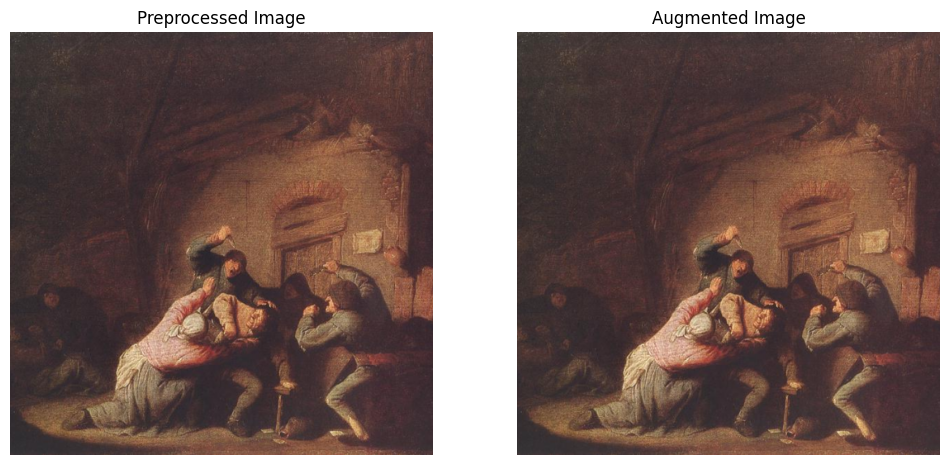

In [144]:
PATH = "scripts/stats/images/artist_dataset/adriaen_van_ostade/adriaen-van-ostade_a-fight-1.jpg"

img = Image.open(PATH).convert("RGB")

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(512),
    torchvision.transforms.CenterCrop(512)
])

#augment = torchvision.transforms.RandomResizedCrop((512, 512), scale=(0.8, 1), ratio=(0.8, 1.25))
#augment = torchvision.transforms.GaussianBlur((5,5), (0.5, 2))
#augment = torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
augment = LightingNoise(1)

p_img = preprocess(img)

aug_img = augment(p_img)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(p_img)
ax[0].set_title("Preprocessed Image")
ax[0].axis("off")

ax[1].imshow(aug_img)
ax[1].set_title("Augmented Image")
ax[1].axis("off")

plt.show()

In [7]:
import json, matplotlib.pyplot as plt

In [10]:
folders = {
    "rnd48": "./out/official/20250115_141403",
    "rnd32": "./out/official/20250116_132739",
    "rnd16": "./out/official/20250116_134432"   
}

In [26]:
train_losses, val_losses = {}, {}
test_losses = {}
for instance, folder in folders.items():
    filename = f"{folder}/result.json"
    result = json.load(open(filename, mode="r", encoding="utf-8"))
    train_losses[instance] = result["train_losses"]
    val_losses[instance] = result["val_losses"]
    test_losses[instance] = result["loss"]

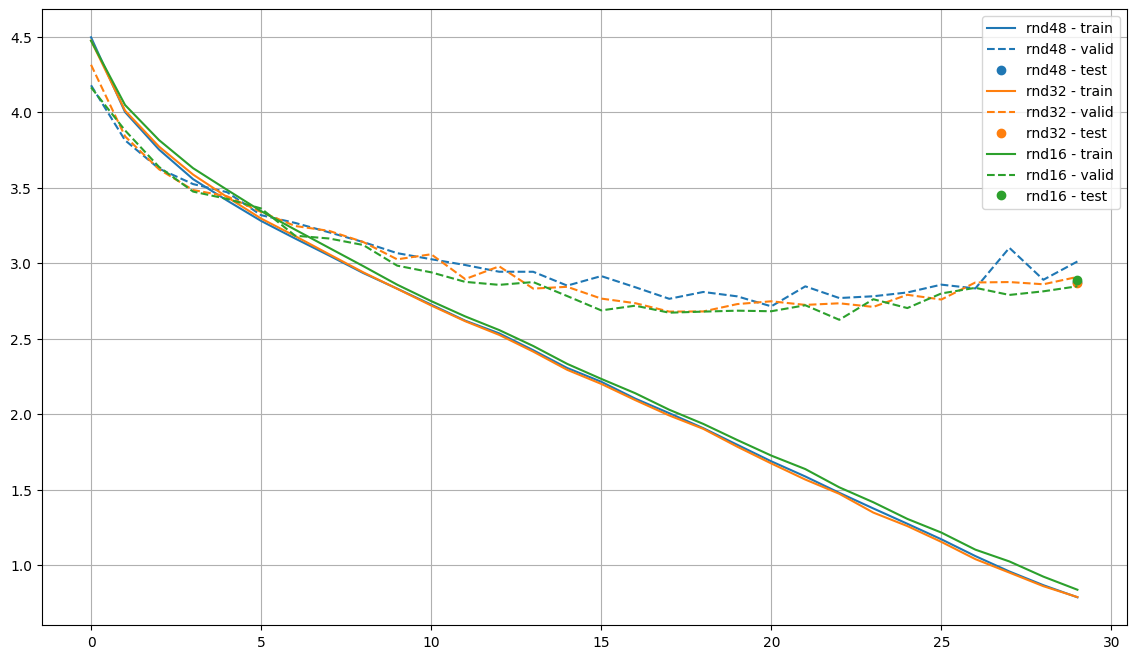

In [32]:
plt.figure(figsize=(14,8))

for ((trn_inst, trn_loss), (val_inst, val_loss), (test_inst, test_loss)) in zip(train_losses.items(), val_losses.items(), test_losses.items()):
    assert trn_inst == val_inst == test_inst, f"Expected match, found {trn_inst}, {val_inst}, {test_inst}"
    
    color = plt.gca()._get_lines.get_next_color()
    plt.plot(trn_loss, label=f"{trn_inst} - train", linestyle="-", color=color)
    plt.plot(val_loss, label=f"{val_inst} - valid", linestyle="--", color=color)
    plt.plot(len(trn_loss)-1, test_loss, 'o', label=f"{test_inst} - test", color=color)
    
plt.grid()
plt.legend()

In [44]:
val_accuracies = {}
test_accuracies = {}
for instance, folder in folders.items():
    filename = f"{folder}/result.json"
    result = json.load(open(filename, mode="r", encoding="utf-8"))
    val_accuracies[instance] = result["val_accuracies"]
    test_accuracies[instance] = result["metrics"]["weighted_top-5_mca"]
    
max_val_accuracies = {inst: (max(values), values.index(max(values)))for inst, values in val_accuracies.items()}

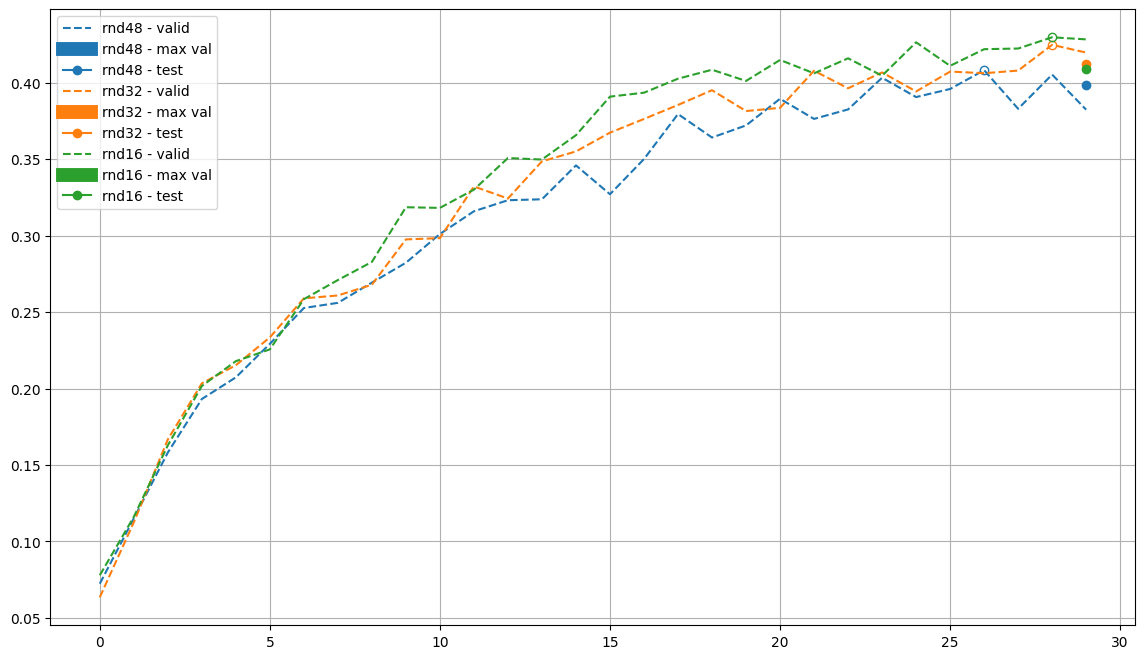

In [60]:
plt.figure(figsize=(14,8))

for ((val_inst, val_loss), (max_val_inst, (max_val_acc, max_index_acc)), (test_inst, test_loss)) in zip(val_accuracies.items(), max_val_accuracies.items(), test_accuracies.items()):
    assert val_inst == max_val_inst == test_inst, f"Expected match, found {val_inst}, {max_val_inst}, {test_inst}"
    
    color = plt.gca()._get_lines.get_next_color()
    plt.plot(val_loss, label=f"{val_inst} - valid", linestyle="--", color=color)
    plt.plot(max_index_acc, max_val_acc, marker='o', fillstyle="none",  label=f"{test_inst} - max val", color=color)
    plt.plot(len(val_loss)-1, test_loss, marker='o', label=f"{test_inst} - test", color=color)
    
plt.grid()
plt.legend()

In [29]:
import torch
import numpy as np

layer = torch.nn.Conv2d(3, 100, 3)

a = torch.rand(4)
#out = layer(a)

v = np.histogram(layer.weight.detach().numpy().ravel(), bins=10)
v, layer.weight.shape

((array([261, 283, 272, 277, 249, 256, 285, 275, 251, 291]),
  array([-1.9244006e-01, -1.5396073e-01, -1.1548139e-01, -7.7002056e-02,
         -3.8522720e-02, -4.3392181e-05,  3.8435951e-02,  7.6915294e-02,
          1.1539462e-01,  1.5387395e-01,  1.9235326e-01], dtype=float32)),
 torch.Size([100, 3, 3, 3]))

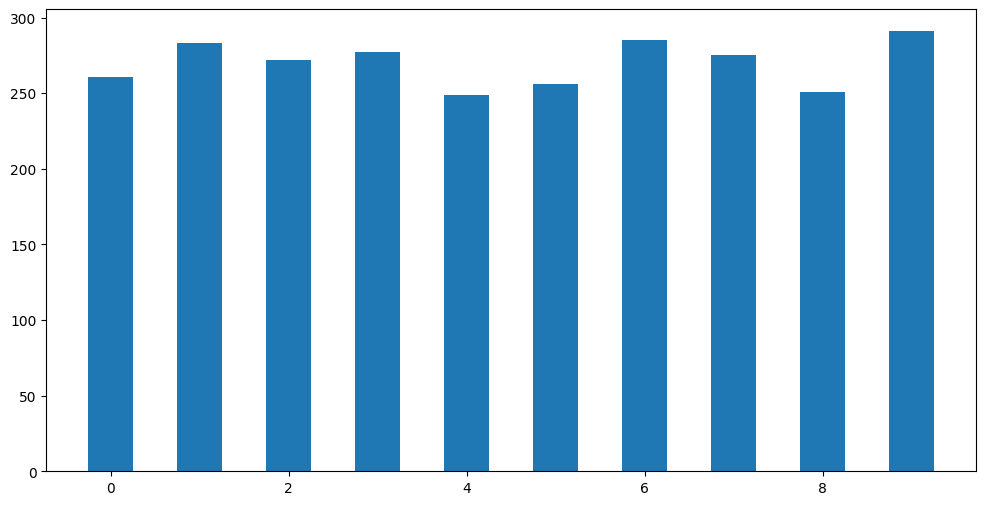

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(range(len(v[0])), v[0], width=0.5)
plt.show()

In [31]:
s = """
### Evaluation mode
Processed 25 batches: loss 1.7762666177749633, mIoU: 0.23859721422195435
Processed 50 batches: loss 1.8186339545249939, mIoU: 0.22922639548778534
Processed 75 batches: loss 1.8103870423634847, mIoU: 0.23448266088962555
Processed 100 batches: loss 1.8041630482673645, mIoU: 0.23582755029201508
Epoch: [1/20], Validation Loss: 1.8160, mIoU: 23.51%
### Evaluation mode
Processed 25 batches: loss 1.9858517932891846, mIoU: 0.23087041079998016
Processed 50 batches: loss 2.079498815536499, mIoU: 0.21276946365833282
Processed 75 batches: loss 2.0348230091730755, mIoU: 0.21697156131267548
Processed 100 batches: loss 2.0424960327148436, mIoU: 0.2167549431324005
Epoch: [2/20], Validation Loss: 2.0516, mIoU: 21.48%
### Evaluation mode
Processed 25 batches: loss 2.5564755725860597, mIoU: 0.2403295487165451
Processed 50 batches: loss 2.5987351965904235, mIoU: 0.22148479521274567
Processed 75 batches: loss 2.5062953742345173, mIoU: 0.2232857346534729
Processed 100 batches: loss 2.501150552034378, mIoU: 0.22317565977573395
Epoch: [3/20], Validation Loss: 2.5059, mIoU: 22.32%
### Evaluation mode
Processed 25 batches: loss 1.7046942687034607, mIoU: 0.26785099506378174
Processed 50 batches: loss 1.7649435317516327, mIoU: 0.2502310276031494
Processed 75 batches: loss 1.721175947189331, mIoU: 0.2608916163444519
Processed 100 batches: loss 1.7213750314712524, mIoU: 0.2619895040988922
Epoch: [4/20], Validation Loss: 1.7274, mIoU: 26.12%
### Evaluation mode
Processed 25 batches: loss 2.0357261276245118, mIoU: 0.1832776963710785
Processed 50 batches: loss 1.9587965488433838, mIoU: 0.18892359733581543
Processed 75 batches: loss 1.9288034709294637, mIoU: 0.19314314424991608
Processed 100 batches: loss 1.9177607882022858, mIoU: 0.19365061819553375
Epoch: [5/20], Validation Loss: 1.9005, mIoU: 19.51%
### Evaluation mode
Processed 25 batches: loss 2.0374346923828126, mIoU: 0.17064635455608368
Processed 50 batches: loss 2.0249682688713073, mIoU: 0.16737839579582214
Processed 75 batches: loss 1.9952565224965413, mIoU: 0.16943545639514923
Processed 100 batches: loss 1.9934006488323213, mIoU: 0.17010805010795593
Epoch: [6/20], Validation Loss: 1.9873, mIoU: 17.24%
### Evaluation mode
Processed 25 batches: loss 1.7116975593566894, mIoU: 0.23244920372962952
Processed 50 batches: loss 1.791217291355133, mIoU: 0.21916474401950836
Processed 75 batches: loss 1.7339028930664062, mIoU: 0.23144228756427765
Processed 100 batches: loss 1.7235983216762543, mIoU: 0.23464785516262054
Epoch: [7/20], Validation Loss: 1.7294, mIoU: 23.41%
### Evaluation mode
Processed 25 batches: loss 1.8429637718200684, mIoU: 0.2421848177909851
Processed 50 batches: loss 1.8897745490074158, mIoU: 0.23160268366336823
Processed 75 batches: loss 1.8531674480438232, mIoU: 0.23870740830898285
Processed 100 batches: loss 1.8454604160785675, mIoU: 0.2383759766817093
Epoch: [8/20], Validation Loss: 1.8588, mIoU: 23.61%
### Evaluation mode
Processed 25 batches: loss 1.6039345693588256, mIoU: 0.24330134689807892
Processed 50 batches: loss 1.695465269088745, mIoU: 0.22754332423210144
Processed 75 batches: loss 1.668627627690633, mIoU: 0.2288791686296463
Processed 100 batches: loss 1.6690774881839752, mIoU: 0.22907023131847382
Epoch: [9/20], Validation Loss: 1.6741, mIoU: 22.93%
"""

for line in s.split("\n"):
    if "Epoch" in line:
        loss, miou = line.split(":")[1].split(","), line.split(":")[2]

Epoch: [1/20], Validation Loss: 1.8160, mIoU: 23.51%
Epoch: [2/20], Validation Loss: 2.0516, mIoU: 21.48%
Epoch: [3/20], Validation Loss: 2.5059, mIoU: 22.32%
Epoch: [4/20], Validation Loss: 1.7274, mIoU: 26.12%
Epoch: [5/20], Validation Loss: 1.9005, mIoU: 19.51%
Epoch: [6/20], Validation Loss: 1.9873, mIoU: 17.24%
Epoch: [7/20], Validation Loss: 1.7294, mIoU: 23.41%
Epoch: [8/20], Validation Loss: 1.8588, mIoU: 23.61%
Epoch: [9/20], Validation Loss: 1.6741, mIoU: 22.93%


In [17]:
import json, matplotlib.pyplot as plt,numpy as np
results = json.load(open("./out/official/20250117_202044/result.json", mode="r", encoding="utf-8"))
train_losses, val_losses = results["train_losses"], results["val_losses"]
train_losses, val_losses

([4.4289516927353265,
  3.9637093107248176,
  3.7417006608227203,
  3.5675448834382255,
  3.4371400794078566,
  3.3275216036829454,
  3.221107442317338,
  3.102043433307574,
  2.9897841420666924,
  2.905670831686464,
  2.6468956347169548,
  2.55751058677661,
  2.4921452067792416,
  2.432302453908427,
  2.3634252414621155,
  2.2752827082214684,
  2.2143460009889355,
  2.1462988421834748,
  2.112694778832896,
  2.0229545610089756,
  1.9666358696874873,
  1.9124317637419905,
  1.8506470932143515,
  1.7972922175480375,
  1.5588534277831685,
  1.4778978080842002,
  1.4302609511490525,
  1.3857334165609088,
  1.348706439041115,
  1.3168738609950603],
 [4.0963893823288196,
  3.7343020115665455,
  3.507027073721191,
  3.396724724889401,
  3.446479366053289,
  3.2836711502554428,
  3.2197011140123686,
  3.0855980057213173,
  3.01291626601962,
  2.9694334969448684,
  2.769802027611277,
  2.730538298137224,
  2.7143093712964848,
  2.700689155252735,
  2.613157029127955,
  2.60128925793135,
  2.57

In [18]:
values = [train_losses, val_losses]
labels = ["train loss", "validation loss"]
num_epochs = len(train_losses)
save_path = "."
name = "loss"

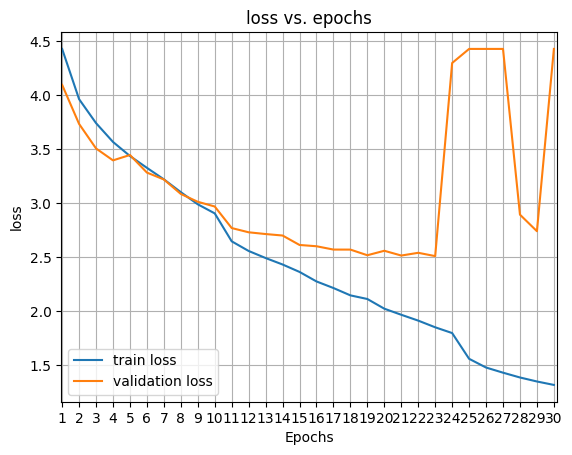

In [22]:
f = plt.figure(name)
for val, label in zip(values, labels):
    plt.plot(np.clip(val, 0, max(train_losses)), label=label)
    plt.title(f"{name} vs. epochs")

plt.xticks(ticks=range(num_epochs), labels=range(1, num_epochs + 1))
plt.xlabel("Epochs")
plt.ylabel(name)
plt.grid(which="both")
plt.legend()
plt.xlim(-0.05, num_epochs - 0.8)
    
f.savefig(f"{save_path}/{name.lower()}.png", dpi=300)

In [2]:
import matplotlib.pyplot as plt
import json

In [3]:
base = "./out/official/20250118_143415/"
hog_lr_1e_4_sch_15_half_wd_1e_4 = "./out/official/20250122_214108/"
hog_lr_5e_5_wd_1e_4 = "./out/official/20250123_200642"


base_res = json.load(open(f"{base}/result.json", mode="r", encoding="utf-8"))
hog_res_1 = json.load(open(f"{hog_lr_1e_4_sch_15_half_wd_1e_4}/result.json", mode="r", encoding="utf-8"))
hog_res_2 = json.load(open(f"{hog_lr_5e_5_wd_1e_4}/result.json", mode="r", encoding="utf-8"))

In [5]:
base_acc = base_res["val_accuracies"]
hog_acc_1 = hog_res_1["val_accuracies"]
hog_acc_2 = hog_res_2["val_accuracies"]

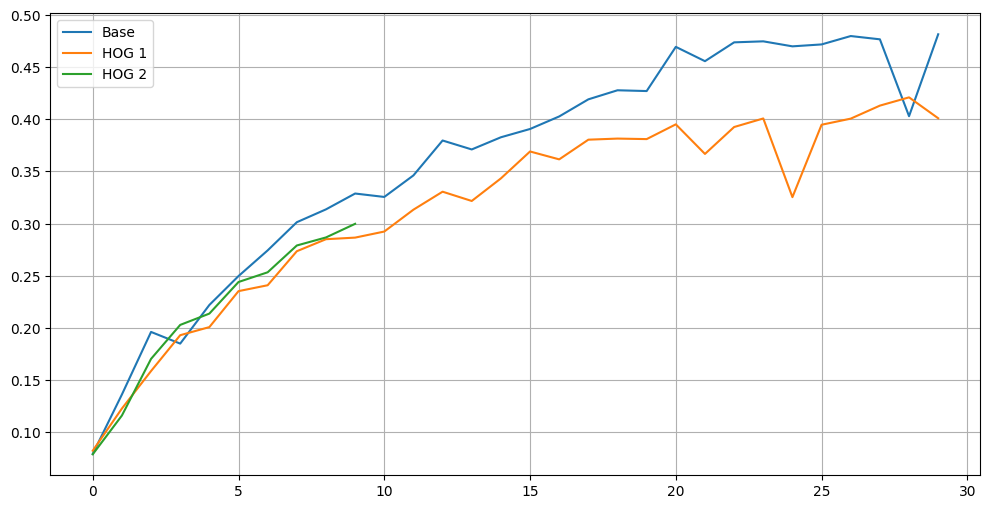

In [6]:
plt.figure(figsize=(12, 6))

plt.plot(base_acc, label="Base")
plt.plot(hog_acc_1, label="HOG 1")
plt.plot(hog_acc_2, label="HOG 2")
plt.grid()
plt.legend()

In [8]:
base_train_loss = base_res["train_losses"]
hog_train_loss_1 = hog_res_1["train_losses"]
hog_train_loss_2 = hog_res_2["train_losses"]
base_val_loss = base_res["val_losses"]
hog_val_loss_1 = hog_res_1["val_losses"]
hog_val_loss_2 = hog_res_2["val_losses"]

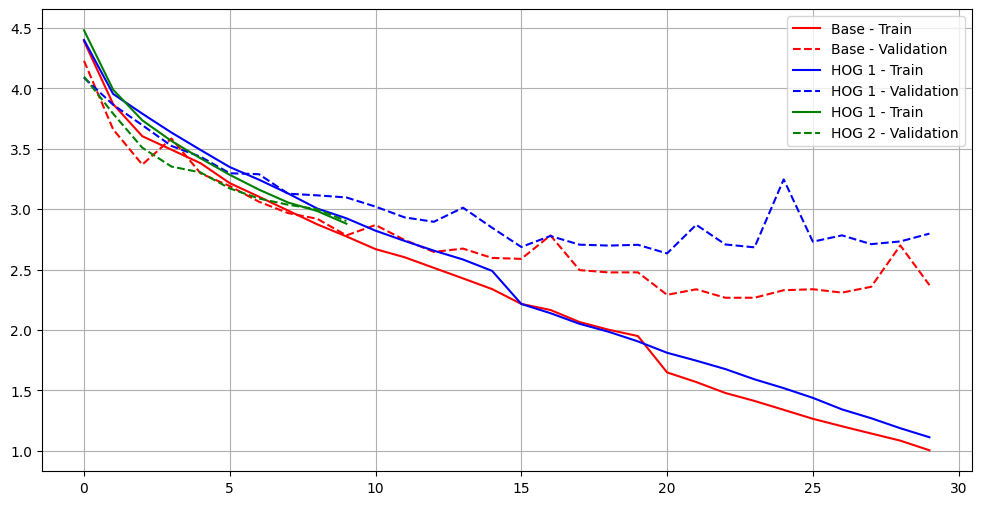

In [11]:
plt.figure(figsize=(12, 6))

plt.plot(base_train_loss, label="Base - Train", color="red", linestyle="-")
plt.plot(base_val_loss, label="Base - Validation", color="red", linestyle="--")
plt.plot(hog_train_loss_1, label="HOG 1 - Train", color="blue", linestyle="-")
plt.plot(hog_val_loss_1, label="HOG 1 - Validation", color="blue", linestyle="--")
plt.plot(hog_train_loss_2, label="HOG 1 - Train", color="green", linestyle="-")
plt.plot(hog_val_loss_2, label="HOG 2 - Validation", color="green", linestyle="--")
plt.grid()
plt.legend()

In [1]:
import matplotlib.pyplot as plt
import json

In [2]:
folders = [
    "./out/official/20250127_161040/",
    "./out/official/20250127_182418/",
    "./out/official/20250127_184140/",
    "./out/official/20250127_190634/"
]

In [5]:
train_losses, val_losses = {}, {}
val_accuracies = {}

for folder in folders:
    data = json.load(open(f"{folder}/result.json", mode="r", encoding="utf-8"))
    label = data["train"]["lr"]
    train_losses[label] = data["train_losses"]
    val_losses[label] = data["val_losses"]
    val_accuracies[label] = data["val_accuracies"]

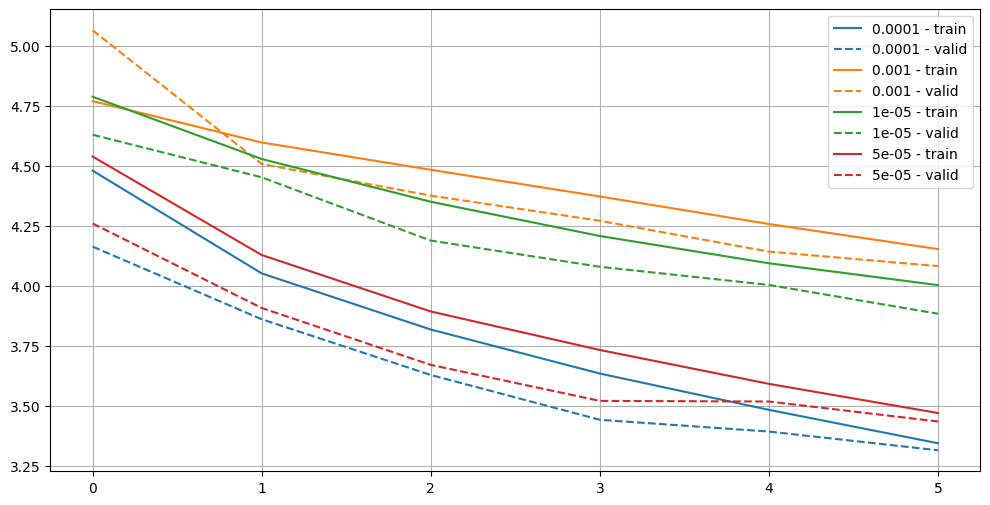

In [7]:
plt.figure(figsize=(12, 6))

for (label, trn_loss), (label, val_loss) in zip(train_losses.items(), val_losses.items()):
    color = plt.gca()._get_lines.get_next_color()
    plt.plot(trn_loss, label=f"{label} - train", linestyle="-", color=color)
    plt.plot(val_loss, label=f"{label} - valid", linestyle="--", color=color)

plt.grid()
plt.legend()

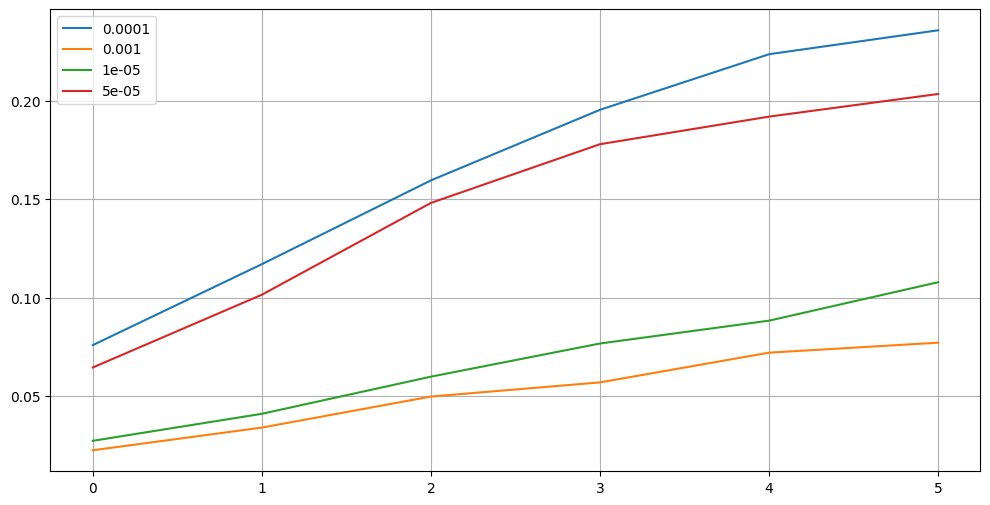

In [10]:
plt.figure(figsize=(12, 6))

for label, val_acc in val_accuracies.items():
    color = plt.gca()._get_lines.get_next_color()
    plt.plot(val_acc, label=f"{label}", linestyle="-", color=color)

plt.grid()
plt.legend()

## Log printing

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum

In [25]:
PATH = "out/official/"

In [15]:
class Curve(Enum):
    TRAIN = 0
    VALID = 1
    BOTH = 2

In [32]:
def plot_curve_log(log_string, curve_type, label):
    
    test = False
    train_loss = []
    val_loss = []
    for line in log_string.split("\n"):
        line = line.strip()
        
        if line.startswith("INFO:root:"):
            line = line[10:]
        else:
            continue
        
        if line.startswith("Training epoch") and "Iteration 1," not in line:
            train_loss.append(float(line.split(":")[1].strip()))
            
        if line.startswith("Validation iteration") and not test and "iteration 1," not in line :
            val_loss.append(float(line.split(":")[1].strip()))
        
            
        if line.startswith("Inference..."):
            test = True
            
    print(len(train_loss))
    print(len(val_loss))

    if not curve_type == Curve.VALID:
        plt.plot(train_loss[::], label=f"Train, {label}")
    if not curve_type == Curve.TRAIN:
        plt.plot(np.clip(val_loss[::], 0, 5), label=f"Validation, {label}")

180
114
180
114
180
114
180
114


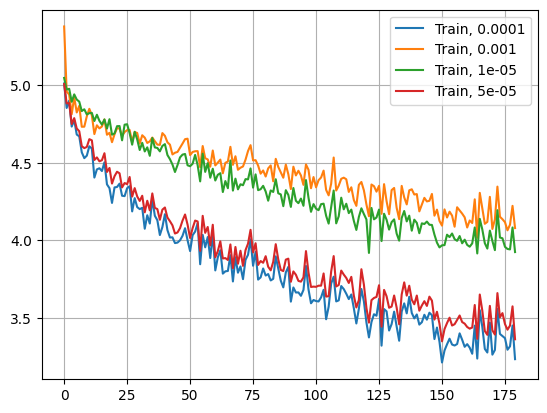

In [33]:
conf_names = [
    "20250127_161040/",
    "20250127_182418/",
    "20250127_184140/",
    "20250127_190634/"
]

curve = Curve.TRAIN
for conf_name in conf_names:
    with open(PATH + conf_name + "log.txt", "r") as f:
        string = f.read()
    with open(f"{PATH}{conf_name}result.json", "r") as f:
        lr = json.load(f)["train"]["lr"]
    plot_curve_log(string, curve, lr)
    
plt.grid()
plt.legend()

In [1]:
import torch
import torch.nn as nn

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, ignore_label=-1, weight=None):
        super(FocalLoss, self).__init__()
        self.ignore_label = ignore_label
        self.gamma = gamma
        self.alpha = alpha
        self.criterion = nn.CrossEntropyLoss(
            weight=weight,
            ignore_index=ignore_label
        )

    def _forward(self, score, target):

        ce_loss = self.criterion(score, target)
        
        pt = torch.exp(-ce_loss)
        focal_loss = torch.pow(1 - pt, self.gamma)

        if self.alpha is not None:
            return self.alpha * focal_loss
        return focal_loss

    def forward(self, score, target):

        # From original configs
        balance_weights = [0.4, 1.0]
        sb_weights = 1.0

        if len(balance_weights) == len(score):
            return sum([w * self._forward(x, target) for (w, x) in zip(balance_weights, score)])
        elif len(score) == 1:
            return sb_weights * self._forward(score[0], target)

        else:
            raise ValueError("lengths of prediction and target are not identical!")

In [9]:
criterion = FocalLoss(gamma=2, alpha=None, ignore_label=-1, weight=None)

import torch

# Randomly generate possible output and target for semantic segmentation
output = torch.randn(1, 5, 256, 256)  # Example output tensor with shape (batch_size, num_classes, height, width)
target = torch.randint(1, 5, (1, 256, 256))  # Example target tensor with shape (batch_size, height, width)

print(output.shape, target.shape)

criterion(output, target)

torch.Size([1, 5, 256, 256]) torch.Size([1, 256, 256])


ValueError: Expected input batch_size (5) to match target batch_size (1).

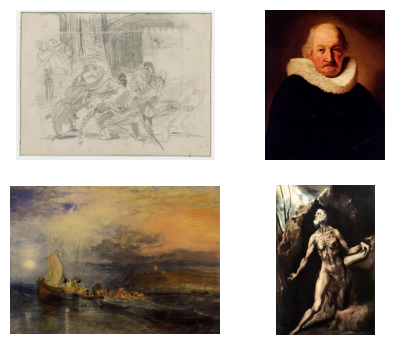

In [59]:
folder = "sample_images"

import os
from PIL import Image
from matplotlib.axes import Axes

images = []
for root, dirs, files in os.walk(folder):
    for file in files:
        img = Image.open(os.path.join(root, file))
        images.append(img)
        
import matplotlib.pyplot as plt

assert len(images) % 2 == 0, "Number of images must be even"

nrows, ncols = 2, len(images) // 2
fig, ax = plt.subplots(nrows, ncols, figsize=(7, 5))

ax: Axes = ax

images[1], images[2] = images[2], images[1]

for i, img in enumerate(images):
    r, c = i // ncols, i % ncols
    
    ax[r, c].imshow(img)
    ax[r, c].axis("off")
    
    #plt.subplots_adjust(wspace=-0.3, hspace=0.1)
    

ax[0,0].set_position([0, 0.35, 0.3, 0.3])
ax[0,1].set_position([0.3, 0.35, 0.3, 0.3])
ax[1,0].set_position([0, 0, 0.3, 0.3])
ax[1,1].set_position([0.3, 0, 0.3, 0.3])
    
plt.savefig("sample_images.jpg", dpi=300)

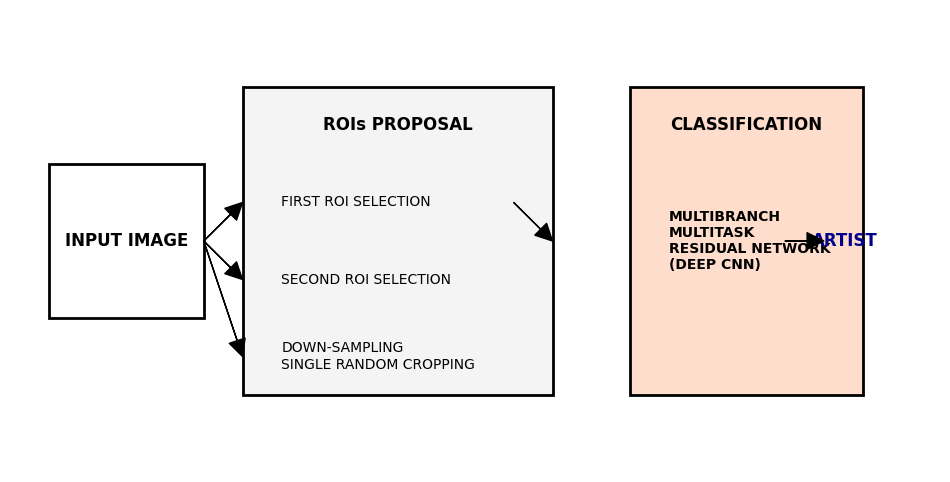

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def draw_exact_diagram():
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 6)
    ax.axis("off")
    
    # Background sections
    ax.add_patch(patches.Rectangle((0.5, 2), 2, 2, edgecolor='black', facecolor='white', lw=2))
    ax.text(1.5, 3, 'INPUT IMAGE', fontsize=12, ha='center', va='center', fontweight='bold')
    
    ax.add_patch(patches.Rectangle((3, 1), 4, 4, edgecolor='black', facecolor='#f4f4f4', lw=2))
    ax.text(5, 4.5, 'ROIs PROPOSAL', fontsize=12, ha='center', va='center', fontweight='bold')
    
    ax.add_patch(patches.Rectangle((8, 1), 3, 4, edgecolor='black', facecolor='#ffddcc', lw=2))
    ax.text(9.5, 4.5, 'CLASSIFICATION', fontsize=12, ha='center', va='center', fontweight='bold')
    
    # ROI Selection Texts
    ax.text(3.5, 3.5, 'FIRST ROI SELECTION', fontsize=10, ha='left', va='center')
    ax.text(3.5, 2.5, 'SECOND ROI SELECTION', fontsize=10, ha='left', va='center')
    ax.text(3.5, 1.5, 'DOWN-SAMPLING\nSINGLE RANDOM CROPPING', fontsize=10, ha='left', va='center')
    
    # Classification Text
    ax.text(8.5, 3, 'MULTIBRANCH\nMULTITASK\nRESIDUAL NETWORK\n(DEEP CNN)', fontsize=10, ha='left', va='center', fontweight='bold')
    
    # Output Labels
    ax.text(11.2, 3, 'ARTIST', fontsize=12, ha='right', va='center', fontweight='bold', color='darkblue')
    
    # Arrows
    arrow_props = dict(facecolor='black', edgecolor='black', width=0.01)
    
    ax.annotate('', xy=(3, 3.5), xytext=(2.5, 3), arrowprops=arrow_props)
    ax.annotate('', xy=(3, 2.5), xytext=(2.5, 3), arrowprops=arrow_props)
    ax.annotate('', xy=(3, 1.5), xytext=(2.5, 3), arrowprops=arrow_props)
    
    ax.annotate('', xy=(7, 3), xytext=(6.5, 3.5), arrowprops=arrow_props)
    ax.annotate('', xy=(10.5, 3), xytext=(10, 3), arrowprops=arrow_props)
    
    plt.show()

draw_exact_diagram()


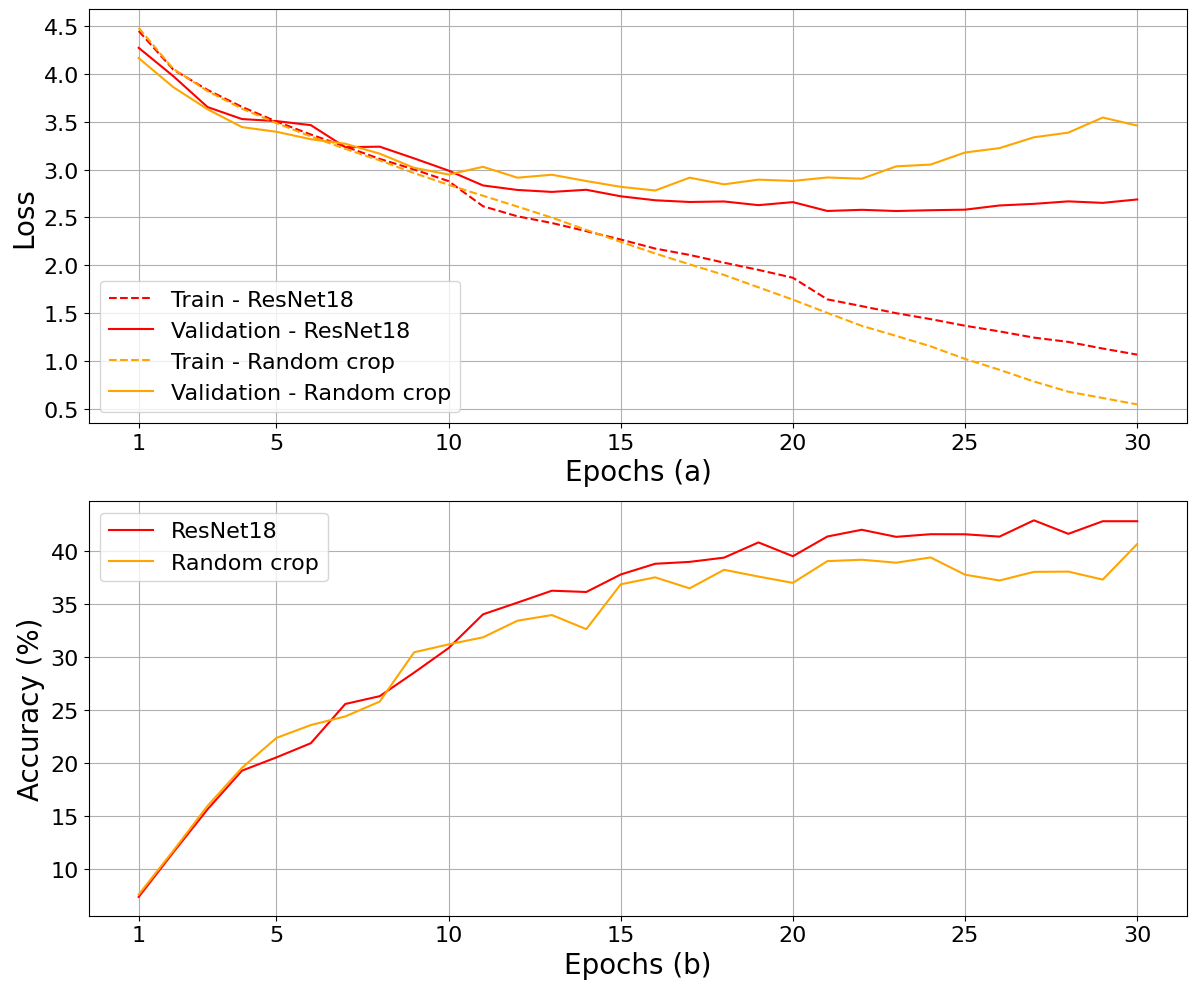

In [9]:
import matplotlib.pyplot as plt
import json

# Funzione per caricare i dati da più file JSON
def load_data_from_files(file_paths):
    data = {}
    for (name, file_path) in file_paths.items():
        with open(file_path, 'r') as f:
            data[name] = json.load(f)
    return data

paths = {
    "ResNet18": 'out/official/20250117_145942/result.json',
    "Random crop": 'out/official/20250204_213851/result.json',
}

data_files = load_data_from_files(paths)

# Crea un colore per ogni file
colors = ['red', 'orange']

# Crea la figura con 2 subplot verticali
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Grafico 1: Train Loss e Validation Loss
for i, (name, data) in enumerate(data_files.items()):
    epochs = list(range(1, len(data['train_losses']) + 1))  # Assicurati che parta da 1
    train_losses = data['train_losses']
    val_losses = data['val_losses']
    
    # Plot per train loss (linea tratteggiata)
    axs[0].plot(epochs, train_losses, label=f'Train - {name}', color=colors[i], linestyle='--')
    # Plot per validation loss (linea continua)
    axs[0].plot(epochs, val_losses, label=f'Validation - {name}', color=colors[i], linestyle='-')

axs[0].set_xlabel('Epochs (a)', fontsize=20)
axs[0].set_ylabel('Loss', fontsize=20)
axs[0].legend(fontsize=16)
axs[0].grid(True)

# Imposta i tick dell'asse X per partire da 1
axs[0].set_xticks([1,5,10,15,20,25,30])  # Imposta esplicitamente i tick da 1 a len(epochs)
axs[0].tick_params(axis='both', which='major', labelsize=16)  # Imposta la dimensione dei numeri dei tick


# Grafico 2: Validation Accuracy
for i, (name, data) in enumerate(data_files.items()):
    epochs = list(range(1, len(data['val_accuracies']) + 1))  # Assicurati che parta da 1
    val_accuracies = [acc * 100 for acc in data['val_accuracies']]  # Moltiplica per 100 per avere la percentuale
    
    # Plot per validation accuracy
    axs[1].plot(epochs, val_accuracies, label=f'{name}', color=colors[i], linestyle='-')

axs[1].set_xlabel('Epochs (b)', fontsize=20)
axs[1].set_ylabel('Accuracy (%)', fontsize=20)
axs[1].legend(fontsize=16)
axs[1].grid(True)

# Imposta i tick dell'asse X per partire da 1
axs[1].set_xticks([1,5,10,15,20,25,30])  # Imposta esplicitamente i tick da 1 a len(epochs)
axs[1].tick_params(axis='both', which='major', labelsize=16)  # Imposta la dimensione dei numeri dei tick

# Mostra i grafici
plt.tight_layout()

plt.savefig("./temp/plot_abl1.png", dpi=300)

plt.show()


In [10]:
data = """This project addresses the challenge of artist identification in digital paintings, a task requiring the extraction of distinctive features to differentiate between artists. We adopt a deep learning-based multi-branch neural network approach, using a Spatial Transformer Network (STN) to identify key regions within paintings, followed by feature extraction using a ResNet-like architecture. Additionally, we enhance the learning process by incorporating hand-crafted features, such as the Histogram of Oriented Gradients (HOG), in parallel with neural features. This combined strategy improves the model's ability to capture intricate artistic patterns. Our experiments compared multiple backbone architectures, including ResNet, MobileNet, and RegNet, assessing their effectiveness in artist classification. The code of our work is available at"""

len(data.split())

112

In [11]:
data = """Deeper neural networks are more difficult to train. We
present a residual learning framework to ease the training
of networks that are substantially deeper than those used
previously. We explicitly reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. We provide comprehensive empirical evidence showing that these residual
networks are easier to optimize, and can gain accuracy from
considerably increased depth. On the ImageNet dataset we
evaluate residual nets with a depth of up to 152 layers—8×
deeper than VGG nets [41] but still having lower complexity. An ensemble of these residual nets achieves 3.57% error
on the ImageNet test set. This result won the 1st place on the
ILSVRC 2015 classification task. We also present analysis
on CIFAR-10 with 100 and 1000 layers.
The depth of representations is of central importance
for many visual recognition tasks. Solely due to our extremely deep representations, we obtain a 28% relative improvement on the COCO object detection dataset. Deep
residual nets are foundations of our submissions to ILSVRC
& COCO 2015 competitions1
, where we also won the 1st
places on the tasks of ImageNet detection, ImageNet localization, COCO detection, and COCO segmentation.
"""

In [12]:
len(data.split())

200

In [10]:
NAME = "resnet_hog"
path = f"./temp/{NAME}.tar"

import torch

chp = torch.load(path, weights_only=False, map_location="cpu")

assert "model_state_dict" in chp

model = chp["model_state_dict"]

torch.save(model, f"./temp/{NAME}.pth")